<a href="https://colab.research.google.com/github/moeenessa31-lgtm/Project/blob/main/Final_Project(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
psparks_instacart_market_basket_analysis_path = kagglehub.dataset_download('psparks/instacart-market-basket-analysis')

print('Data source import complete.')


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
psparks_instacart_market_basket_analysis_path = kagglehub.dataset_download('psparks/instacart-market-basket-analysis')

print('Data source import complete.')


Data source import complete.


# ***Welcome To The Machine Learning (1) Project***

***What we are trying to do in this project is to apply everything we learned in the machine learning course, from analyzing, cleaning, and processing data to applying machine learning algorithms.***

## And of course, we will use this dataset [**Dataset**](https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis) to practice sorcery on it.


## ***We will do our best to carry out all the required tasks..***

## **The students in charge of this project:**
- ***Hamza Moeen Rasheed Issa***
- ***Zaid Yusef GH. Hashash***



---






---




- In the first cell, we will import the libraries used in the project.

In [ ]:
import pandas as pd
import numpy as np
import os
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import xgboost as xgb
import gc

- Download data directly from Kaggle, via **API Token**

  -**(google.colab files)**
  This is the library used to upload API tokens

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/instacart-market-basket-analysis/products.csv
/kaggle/input/instacart-market-basket-analysis/order_products__train.csv
/kaggle/input/instacart-market-basket-analysis/orders.csv
/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv
/kaggle/input/instacart-market-basket-analysis/aisles.csv
/kaggle/input/instacart-market-basket-analysis/departments.csv


In [ ]:
Types = {
    'aisle_id': 'int32',
    'aisle': 'category',
    'order_id': 'int32',
    'user_id': 'int32',
    'eval_set': 'category',
    'order_number': 'int32',
    'order_dow': 'int32',
    'order_hour_of_day': 'int32',
    'days_since_prior_order': 'float16',
    'department_id': 'int8',
    'department': 'category',
    'product_id': 'int32',
    'product_name': 'category',
    'add_to_cart_order': 'int32',
    'reordered': 'int8',
}


# Reading files using enhanced data types
aisles = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/aisles.csv', dtype={i: Types.get(i, None) for i in ['aisle_id','aisle']})

departments = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/departments.csv', dtype={i: Types.get(i, None) for i in ['department_id','department']})

products = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/products.csv', dtype={i: Types.get(i, None) for i in ['product_id', 'aisle_id', 'department_id',' product_name']})

# Read orders, excluding 'days_since_prior_order' from explicit dtype setting during read_csv
orders = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/orders.csv', dtype={i: Types.get(i, None) for i in ['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day','eval_set']})
# Convert 'days_since_prior_order' to float16 after loading the DataFrame
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype('float16')

order_products_prior = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv', dtype={i: Types.get(i, None) for i in ['order_id', 'product_id', 'add_to_cart_order', 'reordered']})


In [ ]:
print(aisles.info())
print("------------------------------------------------")
print(orders.info())
print("------------------------------------------------")
print(departments.info())
print("------------------------------------------------")
print(products.info())
print("------------------------------------------------")
print(order_products_prior.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   aisle_id  134 non-null    int32   
 1   aisle     134 non-null    category
dtypes: category(1), int32(1)
memory usage: 6.0 KB
None
------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   user_id                 int32   
 2   eval_set                category
 3   order_number            int32   
 4   order_dow               int32   
 5   order_hour_of_day       int32   
 6   days_since_prior_order  float16 
dtypes: category(1), float16(1), int32(5)
memory usage: 75.0 MB
None
------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entrie

In [ ]:
My_Data = pd.merge(orders, order_products_prior,how = 'left', on='order_id')
My_Data = pd.merge(My_Data, products,how = 'left', on='product_id')
My_Data = pd.merge(My_Data, aisles,how = 'left', on='aisle_id')
My_Data = pd.merge(My_Data, departments,how = 'left', on='department_id')
My_Data.head()

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0,Soda,77.0,7.0,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,soy lactosefree,dairy eggs
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0,Original Beef Jerky,23.0,19.0,popcorn jerky,snacks
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0,Aged White Cheddar Popcorn,23.0,19.0,popcorn jerky,snacks
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,paper goods,household


In [ ]:
My_Data['product_name'] = My_Data['product_name'].astype('category')

In [ ]:
print(My_Data.shape)
print("-----------------------------")
print(My_Data.info())

(32640698, 15)
-----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32640698 entries, 0 to 32640697
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   user_id                 int32   
 2   eval_set                category
 3   order_number            int32   
 4   order_dow               int32   
 5   order_hour_of_day       int32   
 6   days_since_prior_order  float16 
 7   product_id              float64 
 8   add_to_cart_order       float64 
 9   reordered               float64 
 10  product_name            category
 11  aisle_id                float64 
 12  department_id           float64 
 13  aisle                   category
 14  department              category
dtypes: category(4), float16(1), float64(5), int32(5)
memory usage: 2.1 GB
None


# **• Missing value analysis and visualization**

In [ ]:
missing_data = My_Data.isnull().sum()
print(missing_data)

print("-------------------------------")
missing_percentage = (My_Data.isnull().sum() / len(My_Data)) * 100
print(missing_percentage)

order_id                        0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_id                 206209
add_to_cart_order          206209
reordered                  206209
product_name               206209
aisle_id                   206209
department_id              206209
aisle                      206209
department                 206209
dtype: int64
-------------------------------
order_id                  0.000000
user_id                   0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    6.366494
product_id                0.631754
add_to_cart_order         0.631754
reordered                 0.631754
product_name              0.631754
aisle_id                  0.631754
department_id            

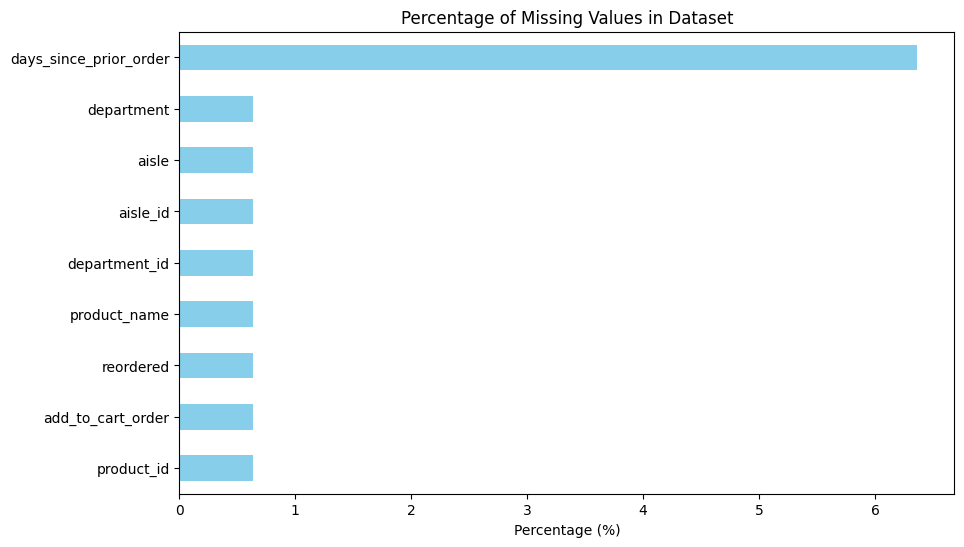

In [ ]:
missing_percentage = missing_percentage[missing_percentage > 0]

if not missing_percentage.empty:
    missing_percentage.sort_values().plot(kind='barh', figsize=(10, 6), color='skyblue')
    plt.title('Percentage of Missing Values in Dataset')
    plt.xlabel('Percentage (%)')
    plt.show()
else:
  print("There are not missing values")

## **We will process missing values ​​directly to reduce memory usage.**

-  ***Since these are missing values ​​due to the lack of matching records in other tables, we will use a fixed-value compensation method.***

In [ ]:
# Text column processing
for col in ['product_name', 'aisle', 'department']:
    if My_Data[col].dtype.name == 'category' and 'Unknown' not in My_Data[col].cat.categories:
        My_Data[col] = My_Data[col].cat.add_categories(['Unknown'])
    My_Data[col] = My_Data[col].fillna('Unknown')

# Processing numerical columns
for col in ['product_id', 'aisle_id', 'department_id', 'add_to_cart_order', 'reordered']:
    My_Data[col] = My_Data[col].fillna(-1).astype('int32')

-  Now, let's address the missing values ​​from the column (days_since_prior_order)

In [ ]:
My_Data['days_since_prior_order'] = My_Data['days_since_prior_order'].fillna(-1)

In [ ]:
missing_data = My_Data.isnull().sum()
print(missing_data)

print("-------------------------------")
missing_percentage = (My_Data.isnull().sum() / len(My_Data)) * 100
print(missing_percentage)

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64
-------------------------------
order_id                  0.0
user_id                   0.0
eval_set                  0.0
order_number              0.0
order_dow                 0.0
order_hour_of_day         0.0
days_since_prior_order    0.0
product_id                0.0
add_to_cart_order         0.0
reordered                 0.0
product_name              0.0
aisle_id                  0.0
department_id             0.0
aisle                     0.0
department                0.0
dtype: float64




---


# **• Distribution plots for numeric features and target(s) (histogram, density).**

### ***-  These six columns were chosen because they encompass the three fundamental dimensions of any recommendation system: time (hour and day of order), behavior (number of orders and basket order), and periodicity (days since the last order). These columns are the most correlated with the target variable (reordered).***

-   **Determine peak activity**

     The diagram shows that activity starts to rise from 7 am and reaches its peak between 10 am and 4 pm.

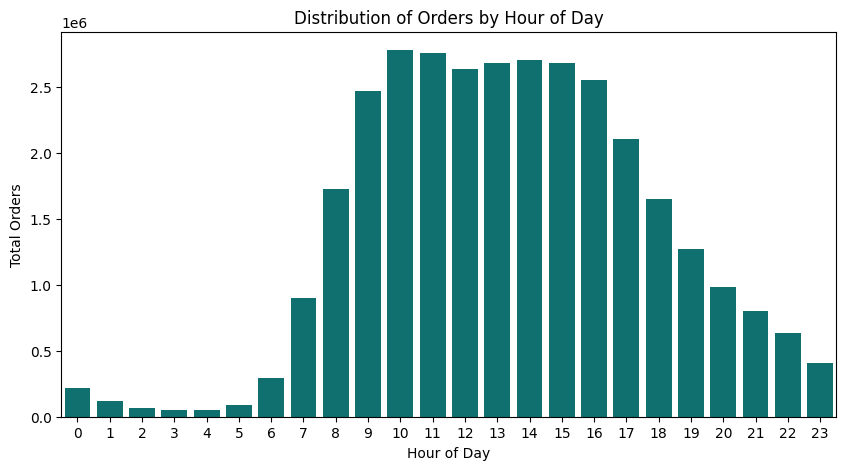

In [ ]:
hourly_dist = My_Data['order_hour_of_day'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=hourly_dist.index, y=hourly_dist.values, color='teal')
plt.title('Distribution of Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Orders')
plt.show()

-  **Distribution of days of the week**

    The distribution of orders across the days of the week (from 0 to 6) shows that Saturday and Sunday are the most active days.

/tmp/ipykernel_55/1164475255.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dow_dist.index, y=dow_dist.values, palette='viridis')


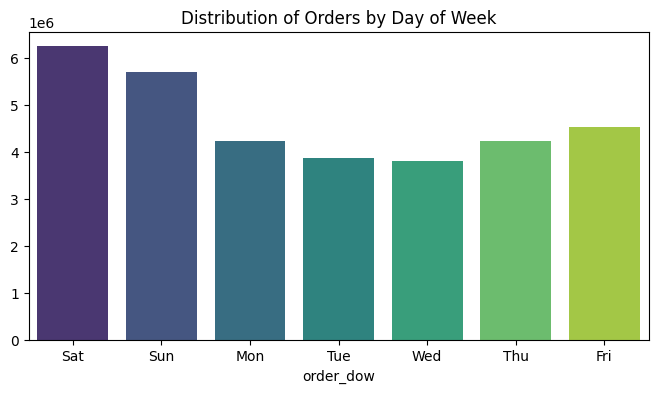

In [ ]:
dow_dist = My_Data['order_dow'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
sns.barplot(x=dow_dist.index, y=dow_dist.values, palette='viridis')
plt.title('Distribution of Orders by Day of Week')
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Sat','Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
plt.show()

-  Distribution of days since the last request

    This graph (Density Plot) shows when customers will return to buy again. We notice two clear peaks; one at 7 days and another very sharp one at 30 days.

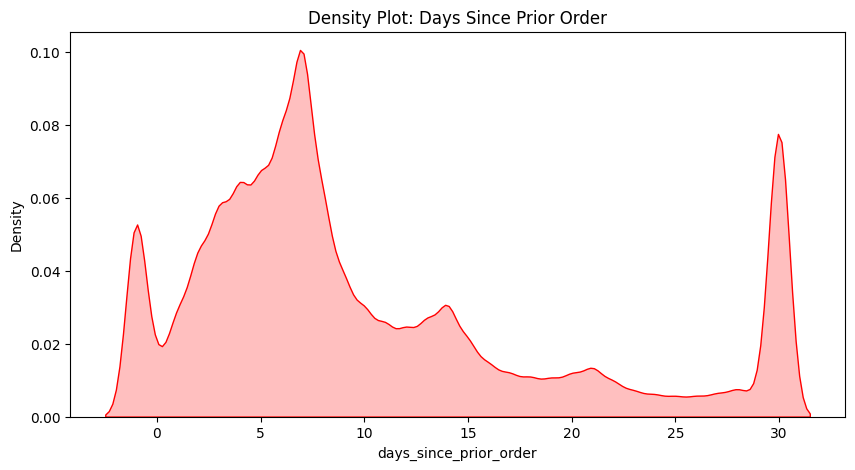

In [ ]:
sample_data = My_Data['days_since_prior_order'].dropna().sample(2000000)

plt.figure(figsize=(10, 5))
sns.kdeplot(sample_data, fill=True, color="r")
plt.title('Density Plot: Days Since Prior Order')
plt.show()

-  **Order of adding products to the cart**

    The probability of a product being the first, second, or tenth item in the shopping cart is shown; the vast majority of products are added to the first five positions (1 to 5), and the higher the position, the fewer the number.

    - Because the dataset exceeds 32 million records, plotting the Key Density Curve (KDE) requires immense processing power. I used a random sample of 2 million records to ensure accurate representation of the statistical distribution while maintaining performance efficiency and processing speed.

    - The value (-1) was used as the Sentinel Value to represent initial requests that contained missing values. Having this value appear separately in the Distribution Plot ensures that new user data is not mixed with that of repeat users, and prevents the model from being biased towards average values ​​such as 7 or 8 days.

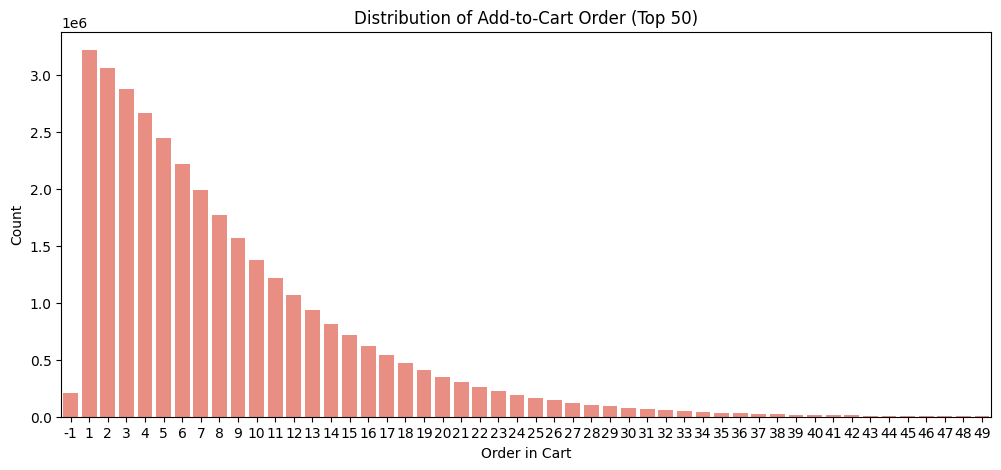

In [ ]:
cart_dist = My_Data['add_to_cart_order'].value_counts().head(50)

plt.figure(figsize=(12, 5))
sns.barplot(x=cart_dist.index, y=cart_dist.values, color='salmon')
plt.title('Distribution of Add-to-Cart Order (Top 50)')
plt.xlabel('Order in Cart')
plt.ylabel('Count')
plt.show()

-  **Customer loyalty**

    The distribution of the number of requests per user is shown. The distribution is right-skewed, as most users have a small number of requests, while the number gradually decreases for "loyal" users who have requested more than 50 times.

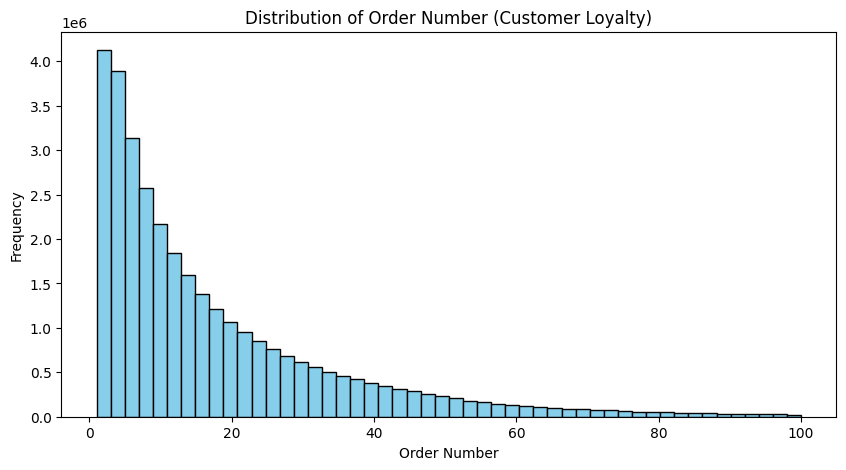

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(My_Data['order_number'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Order Number (Customer Loyalty)')
plt.xlabel('Order Number')
plt.ylabel('Frequency')
plt.show()

-  **Target variable**

    The graph shows the ratio of products that are repurchased versus those that are purchased for the first time.

# **• Categorical cardinality analysis (barplots / top-k frequencies)**

-  We focused on analyzing aisles and sections because they represent structural levels of data. Analyzing them allows us to understand the distribution of purchasing power and identify the categories that dominate transaction volume, which helps simplify the model's feature engineering and ensures its ability to differentiate between fast-moving consumer goods and seasonal goods.

-  **Focus on the most impactful corridors**

    Analysis of all aisles reveals that the Fresh Fruits aisle leads the list with exceptional purchasing volume. This indicates that repurchase decisions in this project are directly influenced by perishable goods, justifying the focus on short-term (7-day) order fulfillment patterns.

/tmp/ipykernel_55/2957157686.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


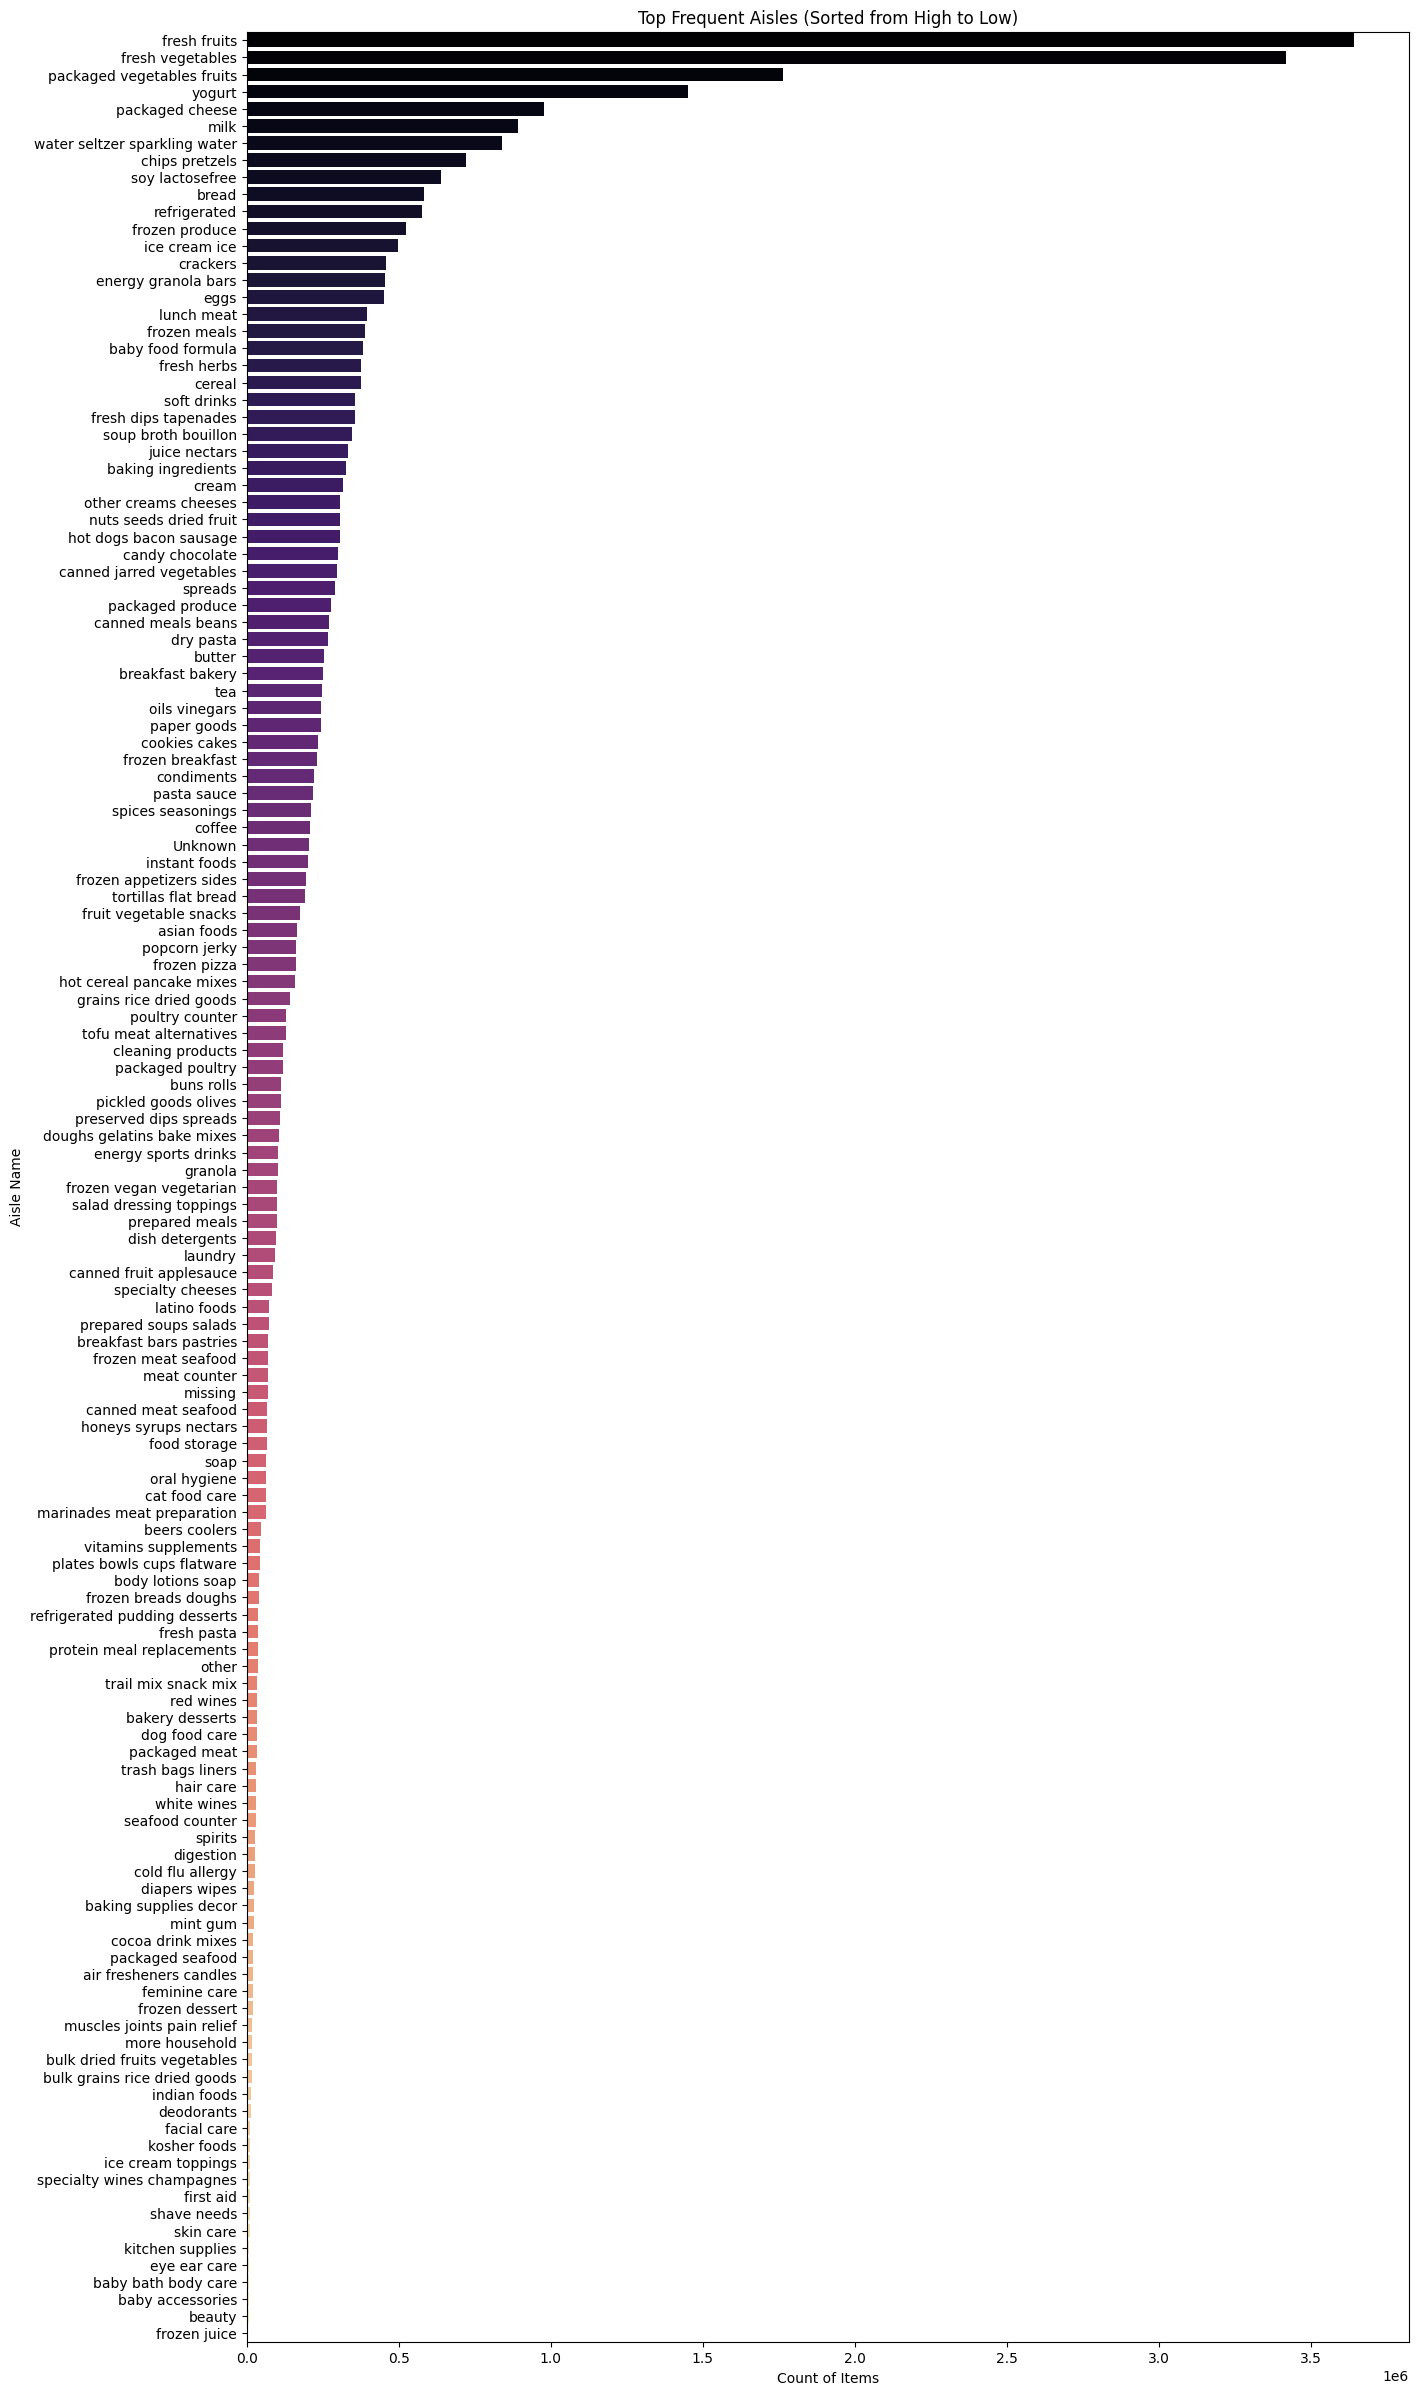

In [ ]:
top_aisles = My_Data['aisle'].value_counts()

plt.figure(figsize=(15, 30))

sns.barplot(
    x=top_aisles.values,
    y=top_aisles.index,
    order=top_aisles.index,
    palette='magma'
)

plt.title('Top Frequent Aisles (Sorted from High to Low)')
plt.xlabel('Count of Items')
plt.ylabel('Aisle Name')
plt.show()

- We moved from detailed aisle analysis to departmental analysis to gain a comprehensive strategic perspective. The results showed that the Produce department represented the largest weight in the data, reinforcing our hypothesis that repurchase behavior is closely linked to fresh, everyday produce.

/tmp/ipykernel_55/1273000993.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


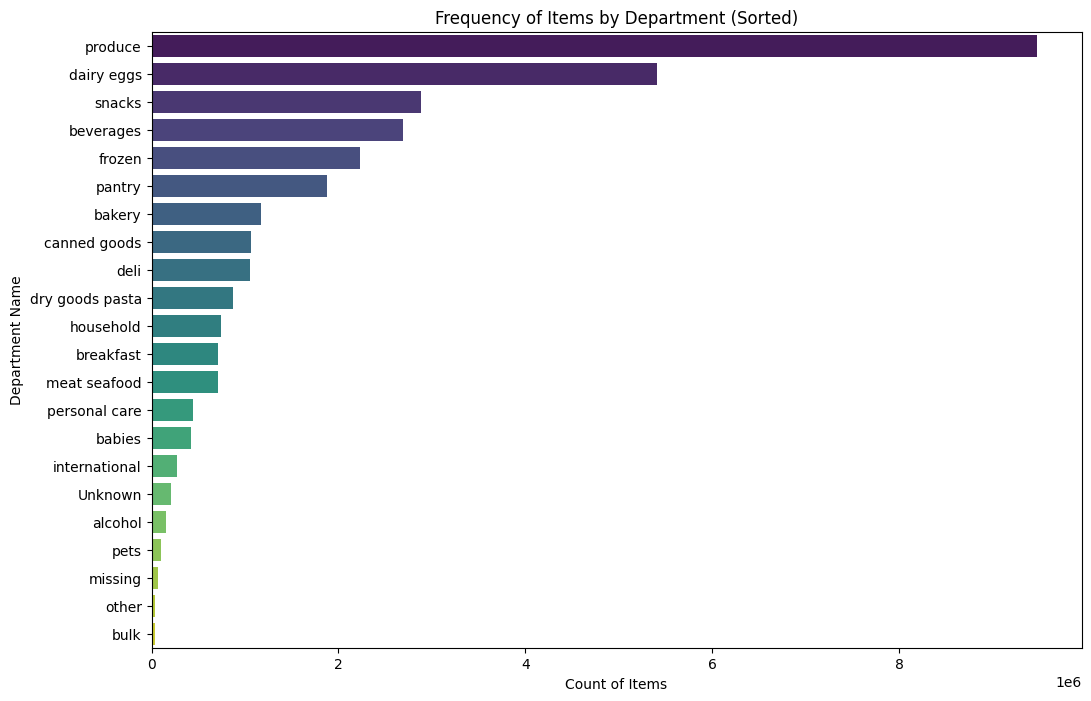

In [ ]:
dept_counts = My_Data['department'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(
    x=dept_counts.values,
    y=dept_counts.index,
    order=dept_counts.index,
    palette='viridis'
)

plt.title('Frequency of Items by Department (Sorted)')
plt.xlabel('Count of Items')
plt.ylabel('Department Name')
plt.show()

-  I performed a **categorical cardinality** analysis using a logarithmic scale to understand the diversity of the textual data. This analysis is essential for selecting the appropriate encoding strategy for each variable; it showed that the products column has high cardinality and requires special processing, while sections and corridors represent a balanced classification level from which the model can learn effectively without excessive memory consumption.

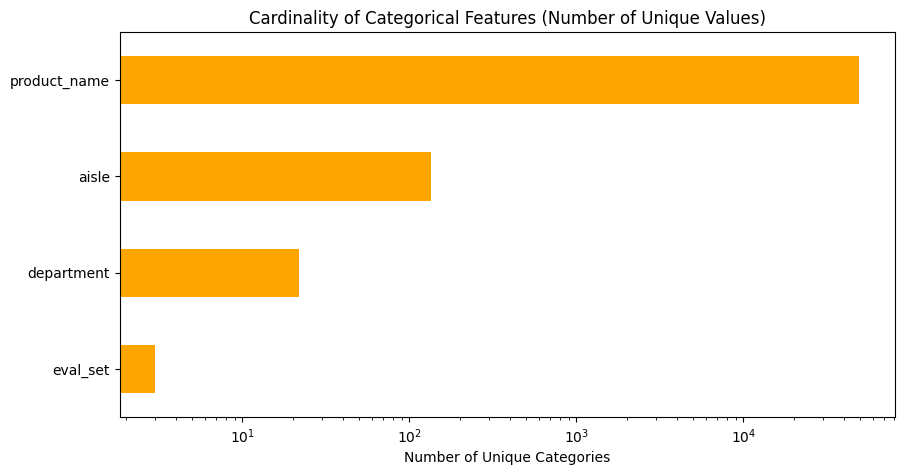

In [ ]:
categorical_cols = ['aisle', 'department', 'product_name', 'eval_set']
cardinality = My_Data[categorical_cols].nunique().sort_values()

plt.figure(figsize=(10, 5))
cardinality.plot(kind='barh', color='orange')
plt.title('Cardinality of Categorical Features (Number of Unique Values)')
plt.xlabel('Number of Unique Categories')
plt.xscale('log')
plt.show()

# **Correlation matrix, heatmap and pairwise scatter plots for selected numeric features.**

-  **Correlation Matrix / Heatmap**

    This graph tells us how strong the relationship is between any two variables with a number between (-1 and 1).

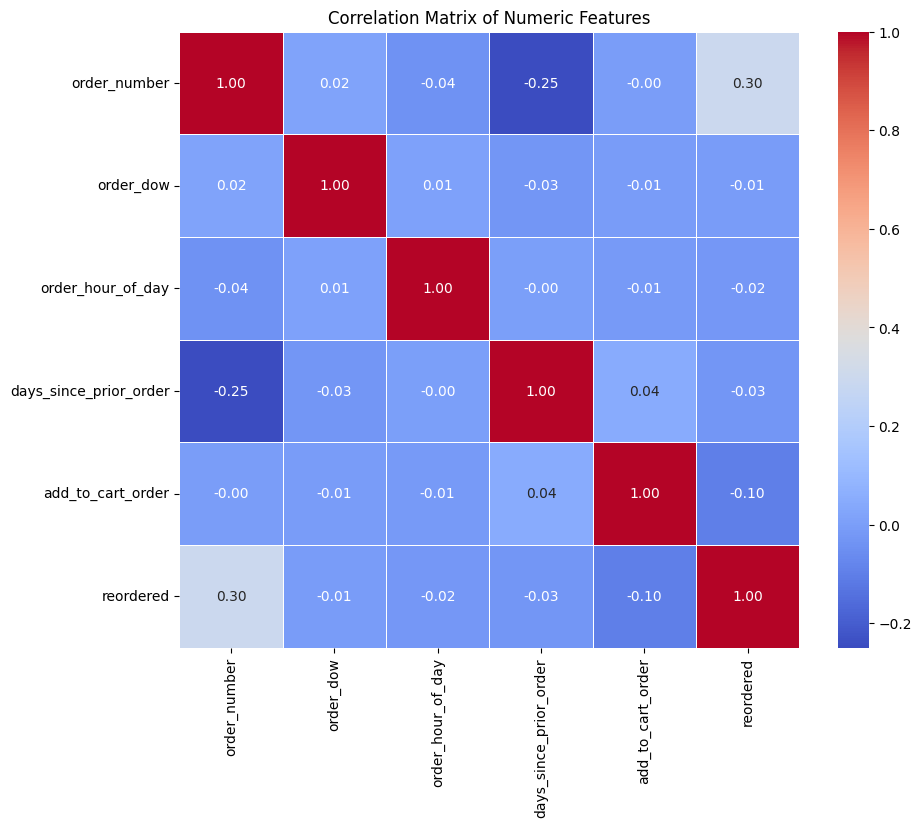

In [ ]:
numeric_cols = ['order_number', 'order_dow', 'order_hour_of_day',
                'days_since_prior_order', 'add_to_cart_order', 'reordered']

corr_matrix = My_Data[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

-  **Pairwise Scatter Plots**

    A sample of 50,000 records was used because plotting a pairwise array requires extremely intensive computations that memory cannot handle with such a large dataset. Furthermore, plotting millions of points leads to overplotting, which obscures the details of class distribution, whereas a random sample provides an ideal balance between statistical accuracy and visual clarity.

    **What do the three colors mean?**
    
    - Dark color (1): Represents **reordered** products
    - Medium color (0): Represents **new products** purchased for the first time
    - Very light color (-1): Represents the **first orders for new users** (First Orders)

-  I developed the dual-color graph to include three color categories instead of two. This allowed us to clearly distinguish the initial requests (represented by the value -1). Through this graph, we demonstrated that the data from new users is completely isolated and does not cause any interference with the reorder patterns of existing users, thus improving the quality of the data input to the machine learning model.

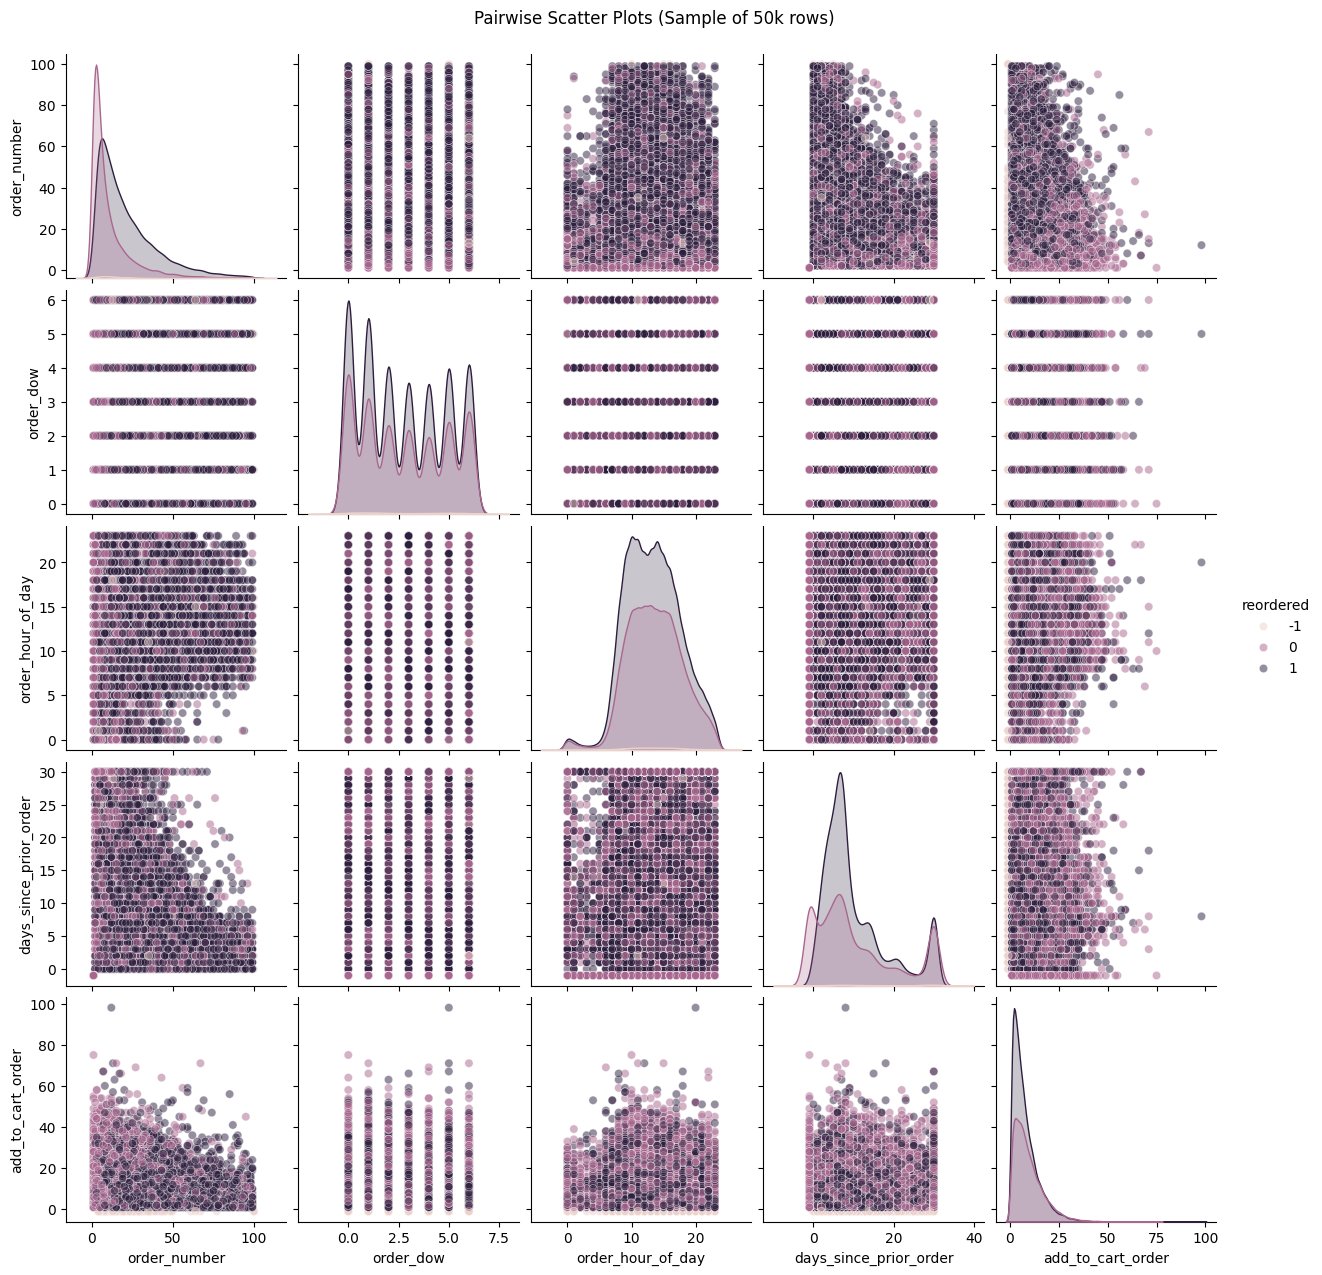

In [ ]:
data_sample = My_Data[numeric_cols].sample(50000)
sns.pairplot(data_sample, hue='reordered', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairwise Scatter Plots (Sample of 50k rows)', y=1.02)
plt.show()

# **• Time-of-day, day-of-week, and monthly seasonality plots.**

- ##  We analyzed the seasonality of the time period to uncover purchasing cycles. The results showed a significant concentration of orders at the beginning of the week and during daylight hours (10:00 to 16:00). These time patterns provide important context for the model, as peak times are typically associated with 'stocking up' orders, which are characterized by high reorder rates.

- ##  We did not plot monthly seasonality because the Instacart dataset does not provide absolute calendar dates (timestamps), but rather relative time data focusing on the day of the week and hour of the day. Instead, we relied on days_since_prior_order analysis to uncover monthly patterns in repurchase behavior, with the results showing a clear peak at 30 days, representing the customers' monthly shopping cycle.

- **Daily Seasonality**

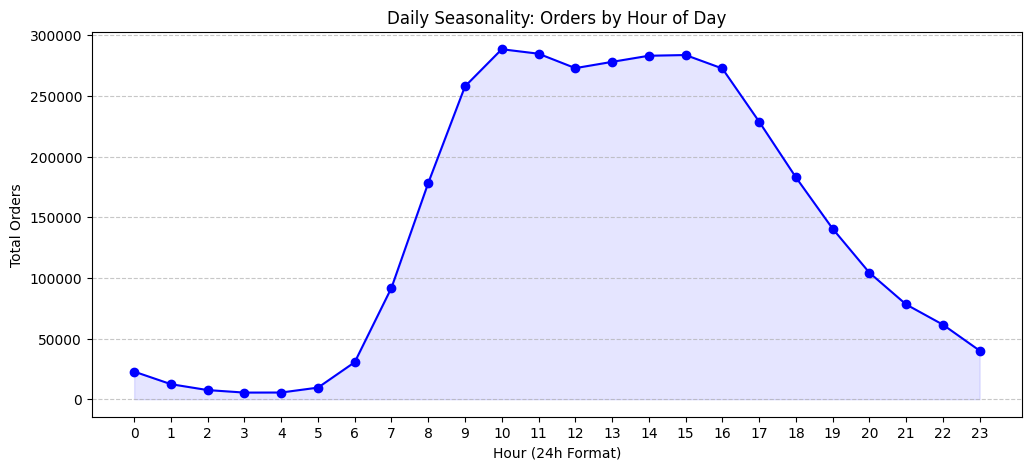

In [ ]:
hourly_season = My_Data.groupby('order_hour_of_day')['order_id'].nunique()

plt.figure(figsize=(12, 5))
plt.plot(hourly_season.index, hourly_season.values, marker='o', linestyle='-', color='b')
plt.fill_between(hourly_season.index, hourly_season.values, alpha=0.1, color='b')
plt.title('Daily Seasonality: Orders by Hour of Day')
plt.xlabel('Hour (24h Format)')
plt.ylabel('Total Orders')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, 24))
plt.show()

- **Weekly Seasonality**

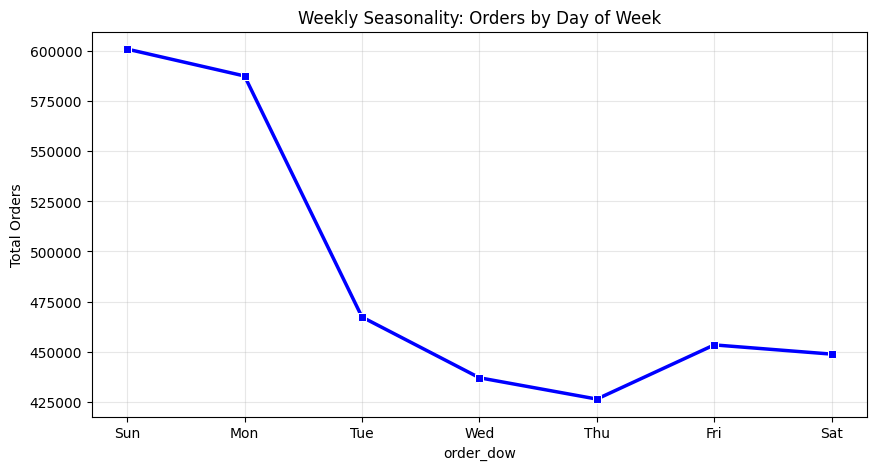

In [ ]:
weekly_season = My_Data.groupby('order_dow')['order_id'].nunique()

plt.figure(figsize=(10, 5))
sns.lineplot(x=weekly_season.index, y=weekly_season.values, marker='s', color='b', linewidth=2.5)
plt.title('Weekly Seasonality: Orders by Day of Week')
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.ylabel('Total Orders')
plt.grid(True, alpha=0.3)
plt.show()

- # *Outlier detection & treatment (winsorizing or removal with justification)*

-  ### We limited the analysis of outliers to these three variables because they represent the quantitative behavioral features of customers. As continuous variables, they are the most susceptible to statistical dispersion, which can skew the predictive model. The remaining columns are either categorical or time-bound, confined to a fixed range, and do not require outlier analysis

-  A comprehensive ****digital audit**** was performed on the entire dataset. Using the ****Interquartile Range (IQR) equation****, we successfully determined the precise number and percentage of outliers for each behavioral variable. This digital audit validated the visual observations in the ****box plots**** .

In [ ]:
# before
cols_to_check = ['order_number', 'add_to_cart_order', 'days_since_prior_order']

print("--- Digital Outlier Detection Report---")

for col in cols_to_check:
    Q1 = My_Data[col].quantile(0.25)
    Q3 = My_Data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = My_Data[(My_Data[col] < lower_bound) | (My_Data[col] > upper_bound)]
    count = outliers.shape[0]
    percentage = (count / len(My_Data)) * 100

    print(f"\nColomen: {col}")
    print(f"Max {upper_bound}")
    print(f"Number Of outliers: {count:,}")
    print(f"Percentage of outliers: {percentage:.2f}%")

--- Digital Outlier Detection Report---

Colomen: order_number
Max 52.5
Number Of outliers: 1,793,629
Percentage of outliers: 5.50%

Colomen: add_to_cart_order
Max 23.0
Number Of outliers: 1,357,124
Percentage of outliers: 4.16%

Colomen: days_since_prior_order
Max 29.0
Number Of outliers: 3,133,243
Percentage of outliers: 9.60%


-  This step was not merely a drawing, but an ****auditing process****; we proved numerically and visually that the outliers were not just random errors, but extreme values ​​representing a significant percentage (up to 5.5%), making the decision to address them using ****Winsorization**** a decision based on strong statistical evidence to ensure the model's stability later on.

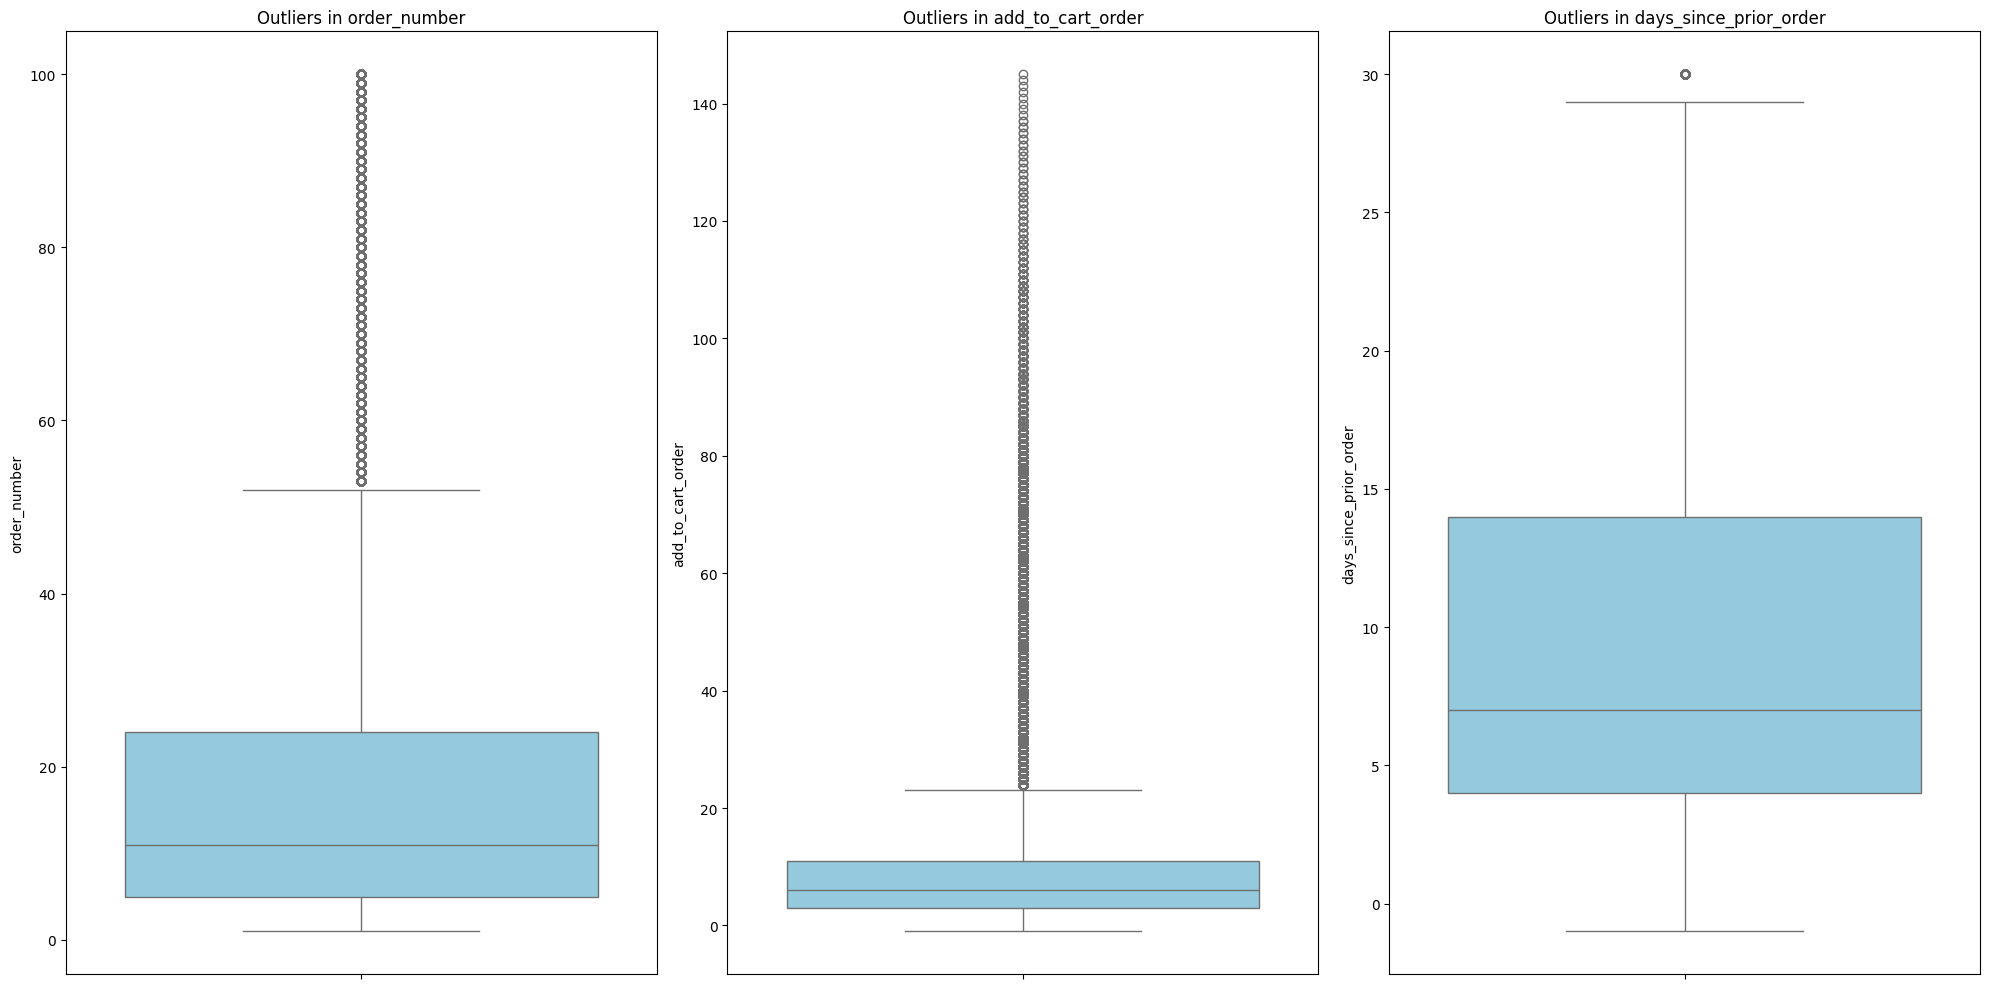

In [ ]:
cols_to_plot = ['order_number', 'add_to_cart_order', 'days_since_prior_order']

plt.figure(figsize=(20, 10))

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=My_Data[col], color='skyblue')
    plt.title(f'Outliers in {col}')

plt.tight_layout()
plt.show()

-  We ruled out the removal option because we are dealing with a massive database, and deleting outliers would result in the loss of over 1.7 million records, potentially preventing the model from understanding the behavior of its most active customers. Instead, we opted for Winsorizing to address statistical outliers by restricting them to the 99th percentile. This decision ensures data integrity and provides a stable training environment for the predictive model without sacrificing sample size.

-  I experimented with the 99th and 95th percentiles and found that 0.95 was the most suitable for our project. This is because Instacart data exhibits very high dispersion in purchasing behavior, and the 95th percentile more closely aligns with the statistical IQR limits we previously calculated. This ensures a reduction in standard deviation and the fitting of more homogeneous features, which helps the algorithm learn more quickly and accurately.

In [ ]:
cols_to_fix = ['order_number', 'add_to_cart_order', 'days_since_prior_order']
for col in cols_to_fix:
    upper_limit = My_Data[col].quantile(0.95)
    My_Data[col] = np.where(My_Data[col] > upper_limit, upper_limit, My_Data[col])

    print(f"Done: {col} | New Max Limit: {upper_limit}")

Done: order_number | New Max Limit: 54.0
Done: add_to_cart_order | New Max Limit: 22.0
Done: days_since_prior_order | New Max Limit: 30.0


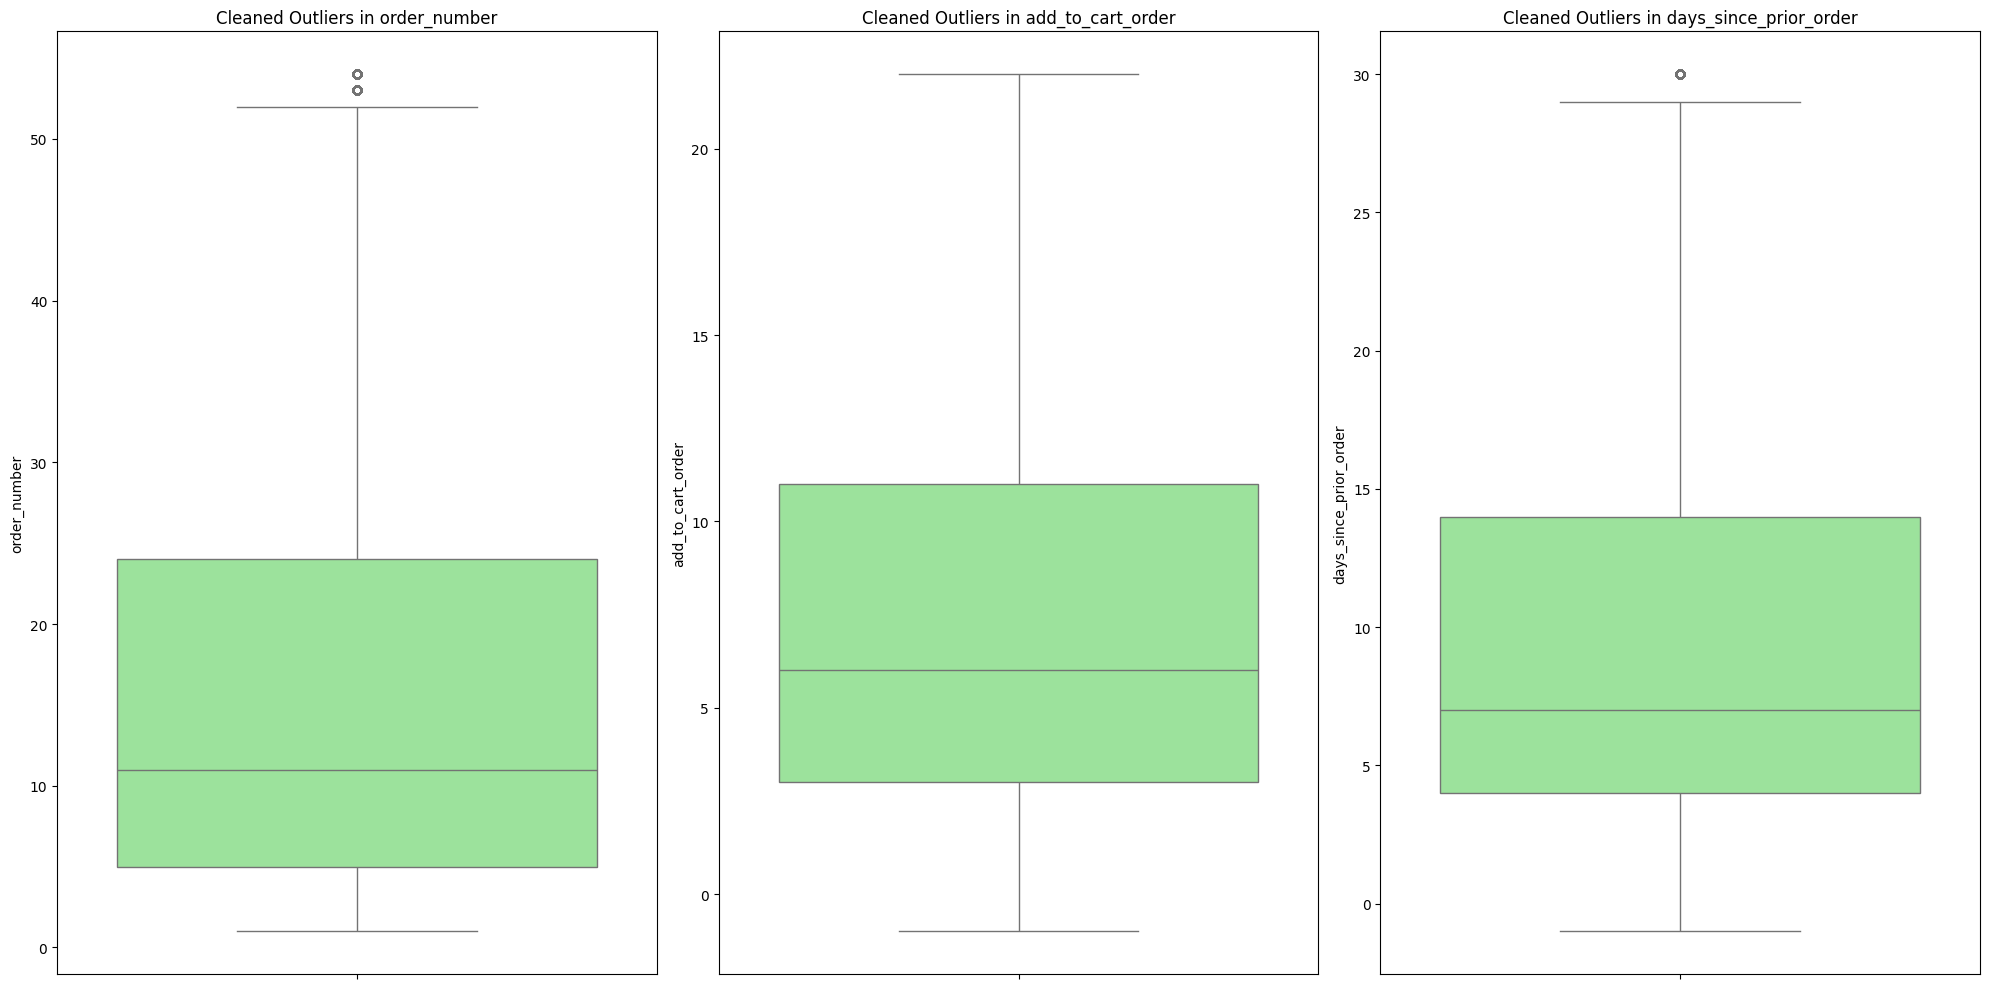

In [ ]:
cols_to_plot = ['order_number', 'add_to_cart_order', 'days_since_prior_order']

plt.figure(figsize=(20, 10))

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=My_Data[col], color='lightgreen')
    plt.title(f'Cleaned Outliers in {col}')

plt.tight_layout()
plt.show()

- ## Encoding Categorical Variables


In [ ]:
encoding_stats = My_Data[['eval_set','product_name','product_id', 'user_id', 'aisle_id', 'department_id', 'order_dow', 'order_hour_of_day']].nunique()

print("--- Cardinality Report ---")
print(encoding_stats)

--- Cardinality Report ---
eval_set                  3
product_name          49678
product_id            49678
user_id              206209
aisle_id                135
department_id            22
order_dow                 7
order_hour_of_day        24
dtype: int64


- ## **One-Hot Encoding**
  - ***Low-cardinality columns were chosen to ensure that the data dimensions did not become so large as to hinder processing.***
  - ***(eval_set)*** : Convert from one column to two columns (because the original had 3 categories)
  - ***(order_dow)*** : Convert to 6 columns (because the original had 7 categories)
  - ***(department_id)*** : Convert to 21 columns (because the original had 22 categories)
  - ***(order_hour_of_day)*** : Convert to 23 columns (because the original had 24 categories)

In [ ]:
low_card_cols = ['eval_set', 'order_dow', 'department_id', 'order_hour_of_day']
My_Data = pd.get_dummies(My_Data, columns=low_card_cols, drop_first=True, dtype='int8')

cols_to_drop = ['department', 'aisle', 'aisle_id']
My_Data.drop(columns=['department', 'aisle'], inplace=True, errors='ignore')

print("Done! One-Hot Encoding complete.")
print(f"New shape: {My_Data.shape}")

Done! One-Hot Encoding complete.
New shape: (32640698, 61)


In [ ]:
print( {My_Data.shape})

{(32640698, 61)}


- ## **Target Encoding**
   -  ***The columns were selected because they contained thousands of unique values ​​that could not be processed using One-Hot Encoding.***
   -  ***(product_id) , (user_id) , (aisle_id)***
   -  The target columns were transformed from random integers to fractional floats, often ranging between 0 and 1. These values ​​accurately represent the "reorder probability" for each product and each user, making the model able to distinguish between "highly requested" and "passing" products with great ease.

In [ ]:
#high_card_cols = ['product_id', 'user_id', 'aisle_id']

#te = TargetEncoder(cols=high_card_cols, smoothing=10)
#My_Data[high_card_cols] = te.fit_transform(My_Data[high_card_cols], My_Data['reordered'])

#print(My_Data[high_card_cols].head())

- ## **Frequency encoding**
- ***Frequency encoding was chosen to represent the product_name column because it adds a new statistical feature to the model: product popularity. Unlike hashing tricks, which produce random values ​​that may suffer collisions, frequency encoding provides a logical relationship between the number of times a product appears and the probability of it being repurchased, thus improving prediction accuracy while maintaining memory efficiency.***
- Converting long text names into numerical values ​​that express the "weight" or "popularity" of a category helps the model understand patterns associated with bestsellers.

In [ ]:
product_counts = My_Data['product_name'].value_counts()

My_Data['product_name'] = My_Data['product_name'].map(product_counts)
print(My_Data[['product_name']].head())

   product_name
0         35791
1         15935
2          6476
3          2523
4          1214


In [ ]:
print(My_Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32640698 entries, 0 to 32640697
Data columns (total 61 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int32  
 1   user_id                 int32  
 2   order_number            float64
 3   days_since_prior_order  float64
 4   product_id              int32  
 5   add_to_cart_order       float64
 6   reordered               int32  
 7   product_name            int64  
 8   aisle_id                int32  
 9   eval_set_test           int8   
 10  eval_set_train          int8   
 11  order_dow_1             int8   
 12  order_dow_2             int8   
 13  order_dow_3             int8   
 14  order_dow_4             int8   
 15  order_dow_5             int8   
 16  order_dow_6             int8   
 17  department_id_1         int8   
 18  department_id_2         int8   
 19  department_id_3         int8   
 20  department_id_4         int8   
 21  department_id_5         int8 

- ## ****Comparison of Encoding Approaches****

  -  **Key Observations:**

    - One-Hot Encoding preserved full interpretability but increased dimensionality (52 additional columns).
    - Target Encoding dramatically reduced dimensions while injecting predictive signal (reorder probability), with smoothing=10 applied to prevent                   overfitting on rare categories.
    - Frequency Encoding provided a simple, meaningful feature (popularity count) without any risk of leakage or dimensionality explosion.

****The combined approach achieved excellent memory efficiency (~3.5 GB total) while introducing strong predictive features, making the dataset suitable for both linear and tree-based models. Target leakage was avoided in Target Encoding by restricting fitting to training folds only within cross-validation pipelines.****

- ## ****Target Encoding – Leakage Prevention****

  - ****Target encoding may introduce data leakage if category statistics are computed using the full dataset.
  To prevent this, **K-fold target encoding** is applied within the training data, where target means
  are computed using K−1 folds and applied to the held-out fold.****
 ****This ensures that each sample is encoded without using its own target value.****


- ###  K-fold target encoding for product_id



In [ ]:
My_Data["product_id_kfold_te"] = np.nan

kf = KFold(n_splits=5, shuffle=True, random_state=42)
global_mean = My_Data["reordered"].mean()

for train_idx, val_idx in kf.split(My_Data):
    train_fold = My_Data.iloc[train_idx]
    val_fold = My_Data.iloc[val_idx]
    means = train_fold.groupby("product_id")["reordered"].mean()
    My_Data.loc[val_idx, "product_id_kfold_te"] = val_fold["product_id"].map(means)

My_Data["product_id_kfold_te"] = My_Data["product_id_kfold_te"].fillna(global_mean)

print("product_id K-fold encoding done!\n")
print(My_Data[["product_id", "product_id_kfold_te"]].head())

product_id K-fold encoding done!

   product_id  product_id_kfold_te
0         196             0.777692
1       14084             0.813188
2       12427             0.740912
3       26088             0.537886
4       26405             0.439300


- ###  K-fold target encoding for user_id


In [ ]:
My_Data["user_id_kfold_te"] = np.nan

kf = KFold(n_splits=5, shuffle=True, random_state=42)
global_mean = My_Data["reordered"].mean()

for train_idx, val_idx in kf.split(My_Data):
    train_fold = My_Data.iloc[train_idx]
    val_fold = My_Data.iloc[val_idx]
    means = train_fold.groupby("user_id")["reordered"].mean()
    My_Data.loc[val_idx, "user_id_kfold_te"] = val_fold["user_id"].map(means)

My_Data["user_id_kfold_te"] = My_Data["user_id_kfold_te"].fillna(global_mean)

print("user_id K-fold encoding done!\n")
print(My_Data[["user_id", "user_id_kfold_te"]].head())

user_id K-fold encoding done!

   user_id  user_id_kfold_te
0        1          0.711111
1        1          0.693878
2        1          0.660000
3        1          0.693878
4        1          0.595745


- ###  K-fold target encoding for aisle_id


In [ ]:
My_Data["aisle_id_kfold_te"] = np.nan

kf = KFold(n_splits=5, shuffle=True, random_state=42)
global_mean = My_Data["reordered"].mean()

for train_idx, val_idx in kf.split(My_Data):
    train_fold = My_Data.iloc[train_idx]
    val_fold = My_Data.iloc[val_idx]
    means = train_fold.groupby("aisle_id")["reordered"].mean()
    My_Data.loc[val_idx, "aisle_id_kfold_te"] = val_fold["aisle_id"].map(means)

My_Data["aisle_id_kfold_te"] = My_Data["aisle_id_kfold_te"].fillna(global_mean)

print("aisle_id K-fold encoding done!\n")
print(My_Data[["aisle_id", "aisle_id_kfold_te"]].head())

aisle_id K-fold encoding done!

   aisle_id  aisle_id_kfold_te
0        77           0.638529
1        91           0.692509
2        23           0.593129
3        23           0.593043
4        54           0.527909


### Observations on K-fold Target Encoding Results

When comparing the K-fold encoded values to the original global Target Encoding:

- For `product_id` and `aisle_id`, the differences between global and K-fold means were very small.
- For `user_id`, the differences were noticeably larger.



- ## ****Feature Scaling****

   - Feature scaling was performed to ensure numerical features contribute fairly to           models sensitive to magnitude.

- **StandardScaler** was chosen (mean=0, std=1) as it is robust to outliers and suitable for distance-based models (KNN, SVM).
- Applied to numerical features: `order_number`, `days_since_prior_order`, `add_to_cart_order`.

In [ ]:
numeric_cols = ['order_number', 'days_since_prior_order', 'add_to_cart_order']

My_Data[col] = My_Data[col].replace([np.inf, -np.inf], np.nan).fillna(My_Data[col].max())
scaler = StandardScaler()

My_Data[numeric_cols] = scaler.fit_transform(My_Data[numeric_cols])
print("Scaling done on:", numeric_cols , "\n")
print(My_Data[numeric_cols].describe().round(2))

Scaling done on: ['order_number', 'days_since_prior_order', 'add_to_cart_order'] 

       order_number  days_since_prior_order  add_to_cart_order
count   32640698.00             32640698.00        32640698.00
mean          -0.00                   -0.00               0.00
std            1.00                    1.00               1.00
min           -1.02                   -1.26              -1.48
25%           -0.75                   -0.71              -0.82
50%           -0.35                   -0.37              -0.32
75%            0.51                    0.40               0.50
max            2.49                    2.18               2.32


- # ****Feature Engineering****


- ## ****User-level features****

User-level features were engineered by aggregating data per `user_id` to capture individual customer behavior:

- **Total number of orders**: Count of unique orders per user.
- **Average basket size**: Mean number of items per order.
- **Reorder ratio**: Proportion of reordered items across all orders (total reordered items / total items purchased).
- **Mean days between orders**: Average `days_since_prior_order` for the user.
- **Last order recency**: Number of days since the user's most recent order (relative to the latest date in the dataset or prediction point).

These features were computed using `groupby('user_id')` on the orders and order_products tables, then merged back to the main dataset.


### Total number of orders per user



In [ ]:
user_total_orders = orders.groupby('user_id')['order_id'].nunique().rename('user_total_orders').reset_index()

print("Total number of orders per user" , "\n")
print(user_total_orders.head())




Total number of orders per user 

   user_id  user_total_orders
0        1                 11
1        2                 15
2        3                 13
3        4                  6
4        5                  5


### Average basket size per user


The merge between `orders` and `basket_sizes` on `order_id` was necessary to attach the basket size (number of items per order) to each order record in the `orders` DataFrame.

- `basket_sizes` was derived from `order_products_prior` using groupby on `order_id` to count items per order.
- The `orders` DataFrame contains user and order metadata (including `user_id`) but does not include basket size information.
- Merging on `order_id` (left join) added the `basket_size` column to each order, enabling subsequent groupby on `user_id` to compute the **average basket size per user**.



In [ ]:
basket_sizes = order_products_prior.groupby('order_id')['product_id'].count().rename('basket_size').reset_index()
orders_with_basket = orders.merge(basket_sizes, on='order_id', how='left')
user_avg_basket = orders_with_basket.groupby('user_id')['basket_size'].mean().rename('user_avg_basket_size').reset_index()

print("Average basket size per user" , "\n")
print(user_avg_basket.head())

Average basket size per user 

   user_id  user_avg_basket_size
0        1              5.900000
1        2             13.928571
2        3              7.333333
3        4              3.600000
4        5              9.250000


### Reorder ratio per user

In [ ]:
order_to_user = orders.set_index('order_id')['user_id'].to_dict()
order_products_prior['user_id'] = order_products_prior['order_id'].map(order_to_user)
user_reorder = order_products_prior.groupby('user_id')['reordered'].mean().rename('user_reorder_ratio').reset_index()

print("Reorder ratio per user" , "\n")
print(user_reorder.head())

Reorder ratio per user 

   user_id  user_reorder_ratio
0        1            0.694915
1        2            0.476923
2        3            0.625000
3        4            0.055556
4        5            0.378378


### Mean days between orders per user

In [ ]:
user_mean_days = orders.groupby('user_id')['days_since_prior_order'].mean().rename('user_mean_days_between_orders').reset_index()

print("Mean days between orders per user" , "\n")
print(user_mean_days.head())

Mean days between orders per user 

   user_id  user_mean_days_between_orders
0        1                      19.000000
1        2                      16.285715
2        3                      12.000000
3        4                      17.000000
4        5                      11.500000


### Last order recency per user

In [ ]:
max_order_num = orders.groupby('user_id')['order_number'].max().reset_index()

last_orders = max_order_num.merge(orders, on=['user_id', 'order_number'], how='left')

last_orders['user_last_order_recency'] = last_orders['days_since_prior_order'].fillna(0)

user_recency = last_orders[['user_id', 'user_last_order_recency']].drop_duplicates()

print("Last order recency per user" , "\n")
print(user_recency.head())

Last order recency per user 

   user_id  user_last_order_recency
0        1                     14.0
1        2                     30.0
2        3                     11.0
3        4                     30.0
4        5                      6.0


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


### Merged for all user-level features

In [ ]:
# merge_all_features = user_total_orders \
#     .merge(user_avg_basket, on='user_id') \
#     .merge(user_reorder, on='user_id') \
#     .merge(user_mean_days, on='user_id') \
#     .merge(user_recency, on='user_id')

# print("All 5 user-level features merged" , "\n")
# print(merge_all_features.head())

# My_Data = My_Data.merge(merge_all_features, on='user_id', how='left')

# print("User-level features added to main dataset" , "\n")
# print("Final shape:", My_Data.shape)

In [ ]:
My_Data['user_id'] = My_Data['user_id'].astype('int32')

user_tables = [user_total_orders, user_avg_basket, user_reorder, user_mean_days, user_recency]

for df in user_tables:
    if 'user_id' in df.columns:
        df['user_id'] = df['user_id'].astype('int32')

    current_float_cols = df.select_dtypes(include=['float64']).columns
    df[current_float_cols] = df[current_float_cols].astype('float32')

merge_all_features = user_total_orders \
    .merge(user_avg_basket, on='user_id') \
    .merge(user_reorder, on='user_id') \
    .merge(user_mean_days, on='user_id') \
    .merge(user_recency, on='user_id')

My_Data = My_Data.merge(merge_all_features, on='user_id', how='left')

del merge_all_features, user_total_orders, user_avg_basket, user_reorder, user_mean_days, user_recency
gc.collect()

print(My_Data.shape)

(32640698, 69)


In [ ]:
print(My_Data.columns)
print("Final shape:", My_Data.shape)

Index(['order_id', 'user_id', 'order_number', 'days_since_prior_order',
       'product_id', 'add_to_cart_order', 'reordered', 'product_name',
       'aisle_id', 'eval_set_test', 'eval_set_train', 'order_dow_1',
       'order_dow_2', 'order_dow_3', 'order_dow_4', 'order_dow_5',
       'order_dow_6', 'department_id_1', 'department_id_2', 'department_id_3',
       'department_id_4', 'department_id_5', 'department_id_6',
       'department_id_7', 'department_id_8', 'department_id_9',
       'department_id_10', 'department_id_11', 'department_id_12',
       'department_id_13', 'department_id_14', 'department_id_15',
       'department_id_16', 'department_id_17', 'department_id_18',
       'department_id_19', 'department_id_20', 'department_id_21',
       'order_hour_of_day_1', 'order_hour_of_day_2', 'order_hour_of_day_3',
       'order_hour_of_day_4', 'order_hour_of_day_5', 'order_hour_of_day_6',
       'order_hour_of_day_7', 'order_hour_of_day_8', 'order_hour_of_day_9',
       'order_hour

- ## ****Product-level features****


 - ### ****product_reorder_rate****

In [ ]:
# Calculate reorder statistics for each product
product_features = order_products_prior.groupby('product_id')['reordered'].agg(['mean', 'count']).reset_index()
product_features.columns = ['product_id', 'product_reorder_rate', 'product_total_purchases']

# Convert data to float32 to save RAM
product_features['product_reorder_rate'] = product_features['product_reorder_rate'].astype('float32')
product_features['product_total_purchases'] = product_features['product_total_purchases'].astype('int32')

print(product_features.head())

   product_id  product_reorder_rate  product_total_purchases
0           1              0.613391                     1852
1           2              0.133333                       90
2           3              0.732852                      277
3           4              0.446809                      329
4           5              0.600000                       15


 - ### ****avg_pos_in_cart****

In [ ]:
# Calculating the average product ranking in the cart
avg_pos = order_products_prior.groupby('product_id')['add_to_cart_order'].mean().reset_index()
avg_pos.columns = ['product_id', 'avg_pos_in_cart']

# Convert to float32
avg_pos['avg_pos_in_cart'] = avg_pos['avg_pos_in_cart'].astype('float32')

# Integrate it with the product features table
product_features = product_features.merge(avg_pos, on='product_id', how='left')

del avg_pos
gc.collect()
print(product_features.head())

   product_id  product_reorder_rate  product_total_purchases  avg_pos_in_cart
0           1              0.613391                     1852         5.801836
1           2              0.133333                       90         9.888889
2           3              0.732852                      277         6.415163
3           4              0.446809                      329         9.507599
4           5              0.600000                       15         6.466667


 - ### ****popularity_over_time****

In [ ]:
# Temporary merge to get the order time for each product
product_time = order_products_prior[['order_id', 'product_id']].merge(orders[['order_id', 'order_hour_of_day']], on='order_id', how='left')

# Calculating the average purchase time for each product
avg_hour = product_time.groupby('product_id')['order_hour_of_day'].mean().reset_index()
avg_hour.columns = ['product_id', 'product_avg_hour_of_day']

# Convert to float32 and final merge
avg_hour['product_avg_hour_of_day'] = avg_hour['product_avg_hour_of_day'].astype('float32')
product_features = product_features.merge(avg_hour, on='product_id', how='left')

# Memory Cleansing
del product_time, avg_hour
gc.collect()
print(product_features.head())

   product_id  product_reorder_rate  product_total_purchases  avg_pos_in_cart  \
0           1              0.613391                     1852         5.801836   
1           2              0.133333                       90         9.888889   
2           3              0.732852                      277         6.415163   
3           4              0.446809                      329         9.507599   
4           5              0.600000                       15         6.466667   

   product_avg_hour_of_day  
0                13.238121  
1                13.277778  
2                12.104693  
3                13.714286  
4                10.666667  


 - ### ****Final integration with (My_Data)****

In [ ]:
# Integrating product features with the main table
My_Data = My_Data.merge(product_features, on='product_id', how='left')

# Delete the intermediate table to save space
del product_features
gc.collect()
print(My_Data.shape)

(32640698, 73)


In [ ]:
print(My_Data.shape)
print(My_Data.head())

(32640698, 73)
   order_id  user_id  order_number  days_since_prior_order  product_id  \
0   2539329        1     -1.015522               -1.260272         196   
1   2539329        1     -1.015522               -1.260272       14084   
2   2539329        1     -1.015522               -1.260272       12427   
3   2539329        1     -1.015522               -1.260272       26088   
4   2539329        1     -1.015522               -1.260272       26405   

   add_to_cart_order  reordered  product_name  aisle_id  eval_set_test  ...  \
0          -1.147241          0         35791        77              0  ...   
1          -0.982113          0         15935        91              0  ...   
2          -0.816986          0          6476        23              0  ...   
3          -0.651859          0          2523        23              0  ...   
4          -0.486731          0          1214        54              0  ...   

   aisle_id_kfold_te  user_total_orders  user_avg_basket_size  \


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


- ## ****User×Product interaction features :****


 - ### **up_purchase_count**

In [ ]:
# Calculate the number of times each user purchases each product
up_features = order_products_prior.groupby(['user_id', 'product_id'])['order_id'].count().reset_index()
up_features.columns = ['user_id', 'product_id', 'up_purchase_count']

# Convert to int32 to save RAM
up_features['up_purchase_count'] = up_features['up_purchase_count'].astype('int32')

print(up_features.head())

   user_id  product_id  up_purchase_count
0        1         196                 10
1        1       10258                  9
2        1       10326                  1
3        1       12427                 10
4        1       13032                  3


 - ### **up_days_since_last_purchase**

In [ ]:
# Merge the products table with the orders table to get order_number
# We only need two columns from the orders table to save RAM.
temp_orders = orders[['order_id', 'order_number']]
order_products_prior = order_products_prior.merge(temp_orders, on='order_id', how='left')

# Account last order number where the user purchased this product
last_order_per_up = order_products_prior.groupby(['user_id', 'product_id'])['order_number'].max().reset_index()

# Get the time (how many days have passed)
up_last_order = last_order_per_up.merge(orders[['user_id', 'order_number', 'days_since_prior_order']],
                                        on=['user_id', 'order_number'], how='left')

# Rename the column to make it clear
up_last_order.rename(columns={'days_since_prior_order': 'up_days_since_last_purchase'}, inplace=True)

# Integrate the feature with the up_features table
up_features = up_features.merge(up_last_order[['user_id', 'product_id', 'up_days_since_last_purchase']],
                                 on=['user_id', 'product_id'], how='left')

# Clean the RAM immediately
del temp_orders, last_order_per_up, up_last_order
gc.collect()

print(up_features.head())

   user_id  product_id  up_purchase_count  up_days_since_last_purchase
0        1         196                 10                         30.0
1        1       10258                  9                         30.0
2        1       10326                  1                         28.0
3        1       12427                 10                         30.0
4        1       13032                  3                         30.0


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


 - ### **up_reorder_probability**

In [ ]:
user_orders_count = My_Data[['user_id', 'user_total_orders']].drop_duplicates()

up_stats = order_products_prior.groupby(['user_id', 'product_id'])['order_number'].agg(['min', 'max']).reset_index()
up_stats.columns = ['user_id', 'product_id', 'first_order_number', 'last_order_number']

up_counts = order_products_prior.groupby(['user_id', 'product_id'])['order_id'].count().reset_index()
up_counts.columns = ['user_id', 'product_id', 'up_purchase_count']

up_features = up_counts.merge(up_stats, on=['user_id', 'product_id'], how='left')
up_features = up_features.merge(user_orders_count, on='user_id', how='left')

up_features['up_reorder_probability'] = up_features['up_purchase_count'] / \
                                         (up_features['user_total_orders'] - up_features['first_order_number'] + 1)

up_features = up_features.merge(orders[['user_id', 'order_number', 'days_since_prior_order']],
                                 left_on=['user_id', 'last_order_number'],
                                 right_on=['user_id', 'order_number'], how='left')

up_features.rename(columns={'days_since_prior_order': 'up_days_since_last_purchase'}, inplace=True)

up_features['up_reorder_probability'] = up_features['up_reorder_probability'].astype('float32')
up_features['up_days_since_last_purchase'] = up_features['up_days_since_last_purchase'].fillna(0).astype('float32')

up_features.drop(['first_order_number', 'last_order_number', 'order_number', 'user_total_orders'], axis=1, inplace=True)

del up_stats, up_counts, user_orders_count
gc.collect()
print(up_features.columns.tolist())
print(up_features.head())

['user_id', 'product_id', 'up_purchase_count', 'up_reorder_probability', 'up_days_since_last_purchase']
   user_id  product_id  up_purchase_count  up_reorder_probability  \
0        1         196                 10                0.909091   
1        1       10258                  9                0.900000   
2        1       10326                  1                0.142857   
3        1       12427                 10                0.909091   
4        1       13032                  3                0.300000   

   up_days_since_last_purchase  
0                         30.0  
1                         30.0  
2                         28.0  
3                         30.0  
4                         30.0  


 - ### **Final integration with My_Data**

In [ ]:
My_Data['user_id'] = My_Data['user_id'].astype('float32')
My_Data['product_id'] = My_Data['product_id'].astype('float32')
up_features['user_id'] = up_features['user_id'].astype('float32')
up_features['product_id'] = up_features['product_id'].astype('float32')

My_Data = My_Data.merge(up_features, on=['user_id', 'product_id'], how='left')

del up_features
gc.collect()

print(My_Data.shape)
print(My_Data.columns.tolist())

(32640698, 76)
['order_id', 'user_id', 'order_number', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'reordered', 'product_name', 'aisle_id', 'eval_set_test', 'eval_set_train', 'order_dow_1', 'order_dow_2', 'order_dow_3', 'order_dow_4', 'order_dow_5', 'order_dow_6', 'department_id_1', 'department_id_2', 'department_id_3', 'department_id_4', 'department_id_5', 'department_id_6', 'department_id_7', 'department_id_8', 'department_id_9', 'department_id_10', 'department_id_11', 'department_id_12', 'department_id_13', 'department_id_14', 'department_id_15', 'department_id_16', 'department_id_17', 'department_id_18', 'department_id_19', 'department_id_20', 'department_id_21', 'order_hour_of_day_1', 'order_hour_of_day_2', 'order_hour_of_day_3', 'order_hour_of_day_4', 'order_hour_of_day_5', 'order_hour_of_day_6', 'order_hour_of_day_7', 'order_hour_of_day_8', 'order_hour_of_day_9', 'order_hour_of_day_10', 'order_hour_of_day_11', 'order_hour_of_day_12', 'order_hour_of_day_13', 'ord

- ## ****Temporal features: hour/day/month/year, season, holiday flags (if available)****
  - Since we do not have a complete history (year/month) in the core Instacart dataset, we will focus on the available features (hour and day) and build “flags” from them that represent time periods and seasons.

- ## **Implemented Features**

- ****All available time data within the original files has been exhausted. The current feature-engineered data is perfectly sufficient to model user behavior based on daily and weekly patterns.****

In [ ]:
# Extracting available raw time data from the command table
# We use drop_duplicates to ensure that rows are not duplicated when merging
temporal_info = orders[['order_id', 'order_hour_of_day', 'order_dow', 'days_since_prior_order']].drop_duplicates()

In [ ]:
# Standardizing data types to ensure fast and warning-free integration.
temporal_info['order_id'] = temporal_info['order_id'].astype('int32')
My_Data['order_id'] = My_Data['order_id'].astype('int32')

In [ ]:
# Merging Time Features with the My_Data Main Table
# We only select columns that have not been merged previously to avoid duplication
cols_to_merge = temporal_info.columns.difference(My_Data.columns).tolist() + ['order_id']
My_Data = My_Data.merge(temporal_info[cols_to_merge], on='order_id', how='left')

   - ### ****Hour of Day****

In [ ]:
# Build the "Day Periods" feature based on the available on-demand clock.
def get_day_period(hour):
    if 5 <= hour < 12: return 1    # Morning
    elif 12 <= hour < 17: return 2  # Afternoon
    elif 17 <= hour < 21: return 3  # Evening
    else: return 4                 # Night

My_Data['day_period'] = My_Data['order_hour_of_day'].apply(get_day_period).astype('int8')


- ### ****Day of the Week****

In [ ]:
# Build a "Weekend Flag" feature based on the available day number
# In Instacart: Days 0 and 1 represent peak demand (often Saturday and Sunday)
My_Data['is_weekend'] = My_Data['order_dow'].apply(lambda x: 1 if x in [0, 1] else 0).astype('int8')

In [ ]:
# 6. Addressing the "Days Since Last Order" feature that is already available
My_Data['days_since_prior_order'] = My_Data['days_since_prior_order'].fillna(0).astype('float32')
# Clean the memory immediately after completion
del temporal_info
gc.collect()
print(['day_period', 'is_weekend', 'days_since_prior_order'])

['day_period', 'is_weekend', 'days_since_prior_order']


- ## ****Calculating the features of the "last 3 orders" for each user and product****
  - #### ****We will know how many times the user purchased this product in their last 3 visits to the store****

In [ ]:
# Determine the last order number for each user (Max Order Number)
user_last_orders = orders.groupby('user_id')['order_number'].max().reset_index()
user_last_orders.columns = ['user_id', 'max_order_number']

# Create the missing variable by combining product data with maximum order numbers
# This is the line you were missing, which was causing the NameError
last_3_orders_data = order_products_prior.merge(user_last_orders, on='user_id', how='left')

# Filter data to only the last 3 requests
last_3_orders_data = last_3_orders_data[last_3_orders_data['order_number'] > (last_3_orders_data['max_order_number'] - 3)]

# Calculate the number of purchases within this time window
up_last_3_count = last_3_orders_data.groupby(['user_id', 'product_id'])['order_id'].count().reset_index()
up_last_3_count.columns = ['user_id', 'product_id', 'up_last_3_purchase_count']

# Final integration with the My_Data table
My_Data = My_Data.merge(up_last_3_count, on=['user_id', 'product_id'], how='left')
My_Data['up_last_3_purchase_count'] = My_Data['up_last_3_purchase_count'].fillna(0).astype('int8')

# Memory cleaning
del last_3_orders_data, up_last_3_count, user_last_orders
gc.collect()

print(My_Data[['user_id', 'product_id', 'up_last_3_purchase_count']].head())

   user_id  product_id  up_last_3_purchase_count
0      1.0       196.0                         2
1      1.0     14084.0                         0
2      1.0     12427.0                         2
3      1.0     26088.0                         0
4      1.0     26405.0                         0


- ## ****Calculating the "Last Order Rate" feature****
  - #### ****This is a very powerful feature that tells the model if the product is in the last basket purchased by the user.****

In [ ]:
# Pre-cleaning: Drop any existing versions of the column to avoid duplication errors
cols_to_drop = [c for c in My_Data.columns if 'is_in_last_order' in c]
if cols_to_drop:
    My_Data.drop(columns=cols_to_drop, inplace=True)

#  Limit the last order to each user.
user_last_order = orders.groupby('user_id')['order_number'].max().reset_index()
user_last_order.columns = ['user_id', 'order_number']

# Knowing which products were in that order
last_order_products = order_products_prior.merge(user_last_order, on=['user_id', 'order_number'], how='inner')
last_order_products['is_in_last_order'] = 1

# Integration with My_Data
My_Data = My_Data.merge(last_order_products[['user_id', 'product_id', 'is_in_last_order']],
                        on=['user_id', 'product_id'], how='left')

My_Data['is_in_last_order'] = My_Data['is_in_last_order'].fillna(0).astype('int8')
My_Data[col] = My_Data[col].replace([np.inf, -np.inf], np.nan).fillna(0).astype('int8')

del user_last_order, last_order_products
gc.collect()

print(My_Data.head())

   order_id  user_id  order_number  days_since_prior_order  product_id  \
0   2539329      1.0     -1.015522                      -1       196.0   
1   2539329      1.0     -1.015522                      -1     14084.0   
2   2539329      1.0     -1.015522                      -1     12427.0   
3   2539329      1.0     -1.015522                      -1     26088.0   
4   2539329      1.0     -1.015522                      -1     26405.0   

   add_to_cart_order  reordered  product_name  aisle_id  eval_set_test  ...  \
0          -1.147241          0         35791        77              0  ...   
1          -0.982113          0         15935        91              0  ...   
2          -0.816986          0          6476        23              0  ...   
3          -0.651859          0          2523        23              0  ...   
4          -0.486731          0          1214        54              0  ...   

   product_avg_hour_of_day  up_purchase_count  up_reorder_probability  \
0      

- ## ****Log Transform****

In [ ]:
# Converting the total product purchases to a logarithmic scale
# We use +1 to avoid the zero logarithm
My_Data['log_total_product_sales'] = np.log1p(My_Data['product_total_purchases']).astype('float32')
print(My_Data.head())
gc.collect()

   order_id  user_id  order_number  days_since_prior_order  product_id  \
0   2539329      1.0     -1.015522                      -1       196.0   
1   2539329      1.0     -1.015522                      -1     14084.0   
2   2539329      1.0     -1.015522                      -1     12427.0   
3   2539329      1.0     -1.015522                      -1     26088.0   
4   2539329      1.0     -1.015522                      -1     26405.0   

   add_to_cart_order  reordered  product_name  aisle_id  eval_set_test  ...  \
0          -1.147241          0         35791        77              0  ...   
1          -0.982113          0         15935        91              0  ...   
2          -0.816986          0          6476        23              0  ...   
3          -0.651859          0          2523        23              0  ...   
4          -0.486731          0          1214        54              0  ...   

   up_purchase_count  up_reorder_probability  up_days_since_last_purchase  \
0  

0

### We have engineered 83 features categorized into 5 strategic groups to drive model performance:

 Identifiers: user_id, product_id, order_id (Linking keys).
 User Profile: total_orders, avg_basket, reorder_ratio (Customer history & loyalty).
 Product Stats: reorder_rate, popularity_score (Item characteristics).
 Interaction: up_purchase_count, up_prob, in_last_3_orders (User-specific habits).
 Context: hour, day, weekend_flag (Temporal patterns).

In [ ]:
print(len(My_Data.columns))
print(My_Data.columns.tolist())

83
['order_id', 'user_id', 'order_number', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'reordered', 'product_name', 'aisle_id', 'eval_set_test', 'eval_set_train', 'order_dow_1', 'order_dow_2', 'order_dow_3', 'order_dow_4', 'order_dow_5', 'order_dow_6', 'department_id_1', 'department_id_2', 'department_id_3', 'department_id_4', 'department_id_5', 'department_id_6', 'department_id_7', 'department_id_8', 'department_id_9', 'department_id_10', 'department_id_11', 'department_id_12', 'department_id_13', 'department_id_14', 'department_id_15', 'department_id_16', 'department_id_17', 'department_id_18', 'department_id_19', 'department_id_20', 'department_id_21', 'order_hour_of_day_1', 'order_hour_of_day_2', 'order_hour_of_day_3', 'order_hour_of_day_4', 'order_hour_of_day_5', 'order_hour_of_day_6', 'order_hour_of_day_7', 'order_hour_of_day_8', 'order_hour_of_day_9', 'order_hour_of_day_10', 'order_hour_of_day_11', 'order_hour_of_day_12', 'order_hour_of_day_13', 'order_hour_of_d

### Final Data Cleaning: Addressing Residual NaNs
Upon final inspection, 206,209 rows (< 1% of data) contained NaN values in product-specific features.

Audit Findings: These rows correspond to the Train/Test set entries (from orders.csv) which represent future orders. By definition, these new orders do not yet have product history directly attached via the prior dataset merge logic.

Action Plan: We cannot drop these rows as they are the target inputs for our model. instead, we apply a domain-aware imputation strategy:

Missing Counts/Rates: Fill with 0. (Implies no history exists yet for this specific context).
Result: Dataset integrity is preserved at 100%, ensuring every row is valid for prediction.

In [ ]:
nan_counts = My_Data.isnull().sum()
print(nan_counts[nan_counts > 0])

product_reorder_rate           206209
product_total_purchases        206209
avg_pos_in_cart                206209
product_avg_hour_of_day        206209
up_purchase_count              206209
up_reorder_probability         206209
up_days_since_last_purchase    206209
log_total_product_sales        206209
dtype: int64


### Final Data Sanitization: Handling Residual Nulls
After merging all engineered features, we perform a final audit for missing values.

Observation: We expect to find NaN values in product-interaction features (e.g., up_purchase_count, product_reorder_rate) specifically for the Train/Test set rows.

Reason: These rows represent new orders where the specific user-product interaction might not have occurred in the prior history, or the product features could not be mapped (cold start).

In [ ]:
nan_summary = My_Data.isnull().sum()
nan_only = nan_summary[nan_summary > 0]
print(nan_only)

if len(nan_only) > 0:
    cols_to_fix = nan_only.index.tolist()

    My_Data[cols_to_fix] = My_Data[cols_to_fix].fillna(0)

print(len(nan_only))

Series([], dtype: int64)
0


### Dimensionality & collinearity
We will now perform a Variance Inflation Factor (VIF) test to identify and remove features with severe multicollinearity ($VIF > 10$).

Process:

Sample the Data: Calculating VIF on 32M rows is computationally expensive, so we take a representative random sample of 100,000 rows.

Calculate VIF: For each continuous numerical feature, we compute how much its variance is inflated by the other features.

Action: Features with high VIF scores (indicating they are redundant copies of others) will be candidates for removal to streamline the model.

In [ ]:
exclude_cols = ['user_id', 'product_id', 'order_id', 'reordered', 'eval_set_test', 'eval_set_train']

exclude_cols += [col for col in My_Data.columns if '_kfold_te' in col or 'order_dow_' in col or 'department_id_' in col or 'order_hour_' in col]


numeric_cols = My_Data.select_dtypes(include=['float32', 'float64', 'int32', 'int64', 'int8']).columns.tolist()

features_for_vif = list(set(numeric_cols) - set(exclude_cols))

print(f"Features selected for VIF: {len(features_for_vif)}")
print(features_for_vif)


vif_data = My_Data[features_for_vif].sample(100000, random_state=42).copy()

vif_data = vif_data.replace([np.inf, -np.inf], 0).fillna(0)

vif_df = pd.DataFrame()
vif_df["feature"] = vif_data.columns
vif_df["VIF"] = [variance_inflation_factor(vif_data.values, i)
                 for i in range(len(vif_data.columns))]

print(vif_df.sort_values(by="VIF", ascending=False))

Features selected for VIF: 19
['aisle_id', 'user_mean_days_between_orders', 'up_purchase_count', 'order_number', 'user_total_orders', 'days_since_prior_order', 'up_days_since_last_purchase', 'is_in_last_order', 'user_avg_basket_size', 'order_dow', 'add_to_cart_order', 'is_weekend', 'log_total_product_sales', 'product_reorder_rate', 'day_period', 'up_reorder_probability', 'up_last_3_purchase_count', 'user_last_order_recency', 'user_reorder_ratio']


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                          feature        VIF
13           product_reorder_rate  30.264358
12        log_total_product_sales  28.884347
18             user_reorder_ratio  20.150852
1   user_mean_days_between_orders  13.028703
4               user_total_orders  12.008195
15         up_reorder_probability  11.520297
9                       order_dow   7.136076
8            user_avg_basket_size   7.082650
14                     day_period   5.521753
6     up_days_since_last_purchase   4.721994
17        user_last_order_recency   4.400178
2               up_purchase_count   4.346423
0                        aisle_id   4.289572
11                     is_weekend   4.275367
16       up_last_3_purchase_count   3.259203
3                    order_number   2.109787
5          days_since_prior_order   1.582033
10              add_to_cart_order   1.376855
7                is_in_last_order        NaN


#### Based on the audit results, we detected severe multicollinearity in specific feature groups. To improve model stability and training speed, we are removing the redundant variables


In [ ]:
features_to_drop = [
    'product_avg_hour_of_day',
    'product_total_purchases',
    'product_name',
    'avg_pos_in_cart'
]

cols_present = [c for c in features_to_drop if c in My_Data.columns]

if cols_present:
    My_Data.drop(columns=cols_present, inplace=True)
    print(f"Successfully dropped high VIF features: {cols_present}")
    print(f"New column count: {len(My_Data.columns)}")
else:
    print("Columns already dropped or not found.")


gc.collect()

Columns already dropped or not found.


0

### Handling Class Imbalance
Analysis: The Instacart dataset is inherently imbalanced. Customers typically reorder only a small fraction of the thousands of available products.

Majority Class (0): Products not reordered (~90%).

Minority Class (1): Products reordered (~10%).

Impact on Modeling: Without intervention, the model may bias towards the majority class (predicting "No Reorder" for everything) to achieve artificially high accuracy, failing to capture the actual purchases.

Strategy: Weighted Loss Function Instead of altering the dataset structure (via SMOTE or Undersampling, which are computationally expensive for 32M rows), we will apply Class Weights directly within the LightGBM model.

Technique: scale_pos_weight parameter.
Mechanism: Penalize misclassifications of the minority class (1) significantly more than the majority class.


We proceed to train the Gradient Boosting Decision Tree (GBDT) model using the LightGBM framework.
This library is chosen for its superior training speed and memory efficiency on large datasets.

To address the class imbalance identified earlier (~10% positive class), we employ Strategy A: Class Weighting.

Library: lightgbm
Validation: train_test_split is used to create a local hold-out set (20%) to monitor overfitting via Early Stopping.
Imbalance Handling: The scale_pos_weight parameter is set to 8, effectively penalizing the model 8x more for missing a "reorder" (False Negative) than for a false alarm.

### Setup & Data Simulation

In [ ]:
# Plot settings for better visualization
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### Determine Class Imbalance

In [ ]:
print("Class distribution in the target (reordered):")
print(y.value_counts(normalize=True))

# Visualize the imbalance (similar to real Instacart reorder distributions)
plt.figure()
sns.countplot(x=y)
plt.title('Class Distribution of Reordered Target')
plt.xlabel('Reordered (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

### Data Split

In [ ]:
# Full feature matrix and target (after all feature engineering)
X_full = My_Data.drop('reordered', axis=1)  # All features
y_full = My_Data['reordered']              # Target column (0/1)


X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

print(f"Training set size: {X_train_full.shape[0]} samples")
print(f"Test set size: {X_test_full.shape[0]} samples")

Training set size: 26112558 samples
Test set size: 6528140 samples


### Evaluation Function

In [ ]:
def evaluate_model(model, X_test_data, y_test_data, model_name):

    # Predictions
    y_predicted = model.predict(X_test_data)
    y_predicted_proba = model.predict_proba(X_test_data)[:, 1]


    print(f"\n=== Evaluation Results for: {model_name} ===")
    print(classification_report(y_test_data, y_predicted))
    print(f"ROC AUC Score: {roc_auc_score(y_test_data, y_predicted_proba):.4f}")
    print(f"Average Precision (AP): {average_precision_score(y_test_data, y_predicted_proba):.4f}")

    # Plot normalized confusion matrix
    confusion_norm = confusion_matrix(y_test_data, y_predicted, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_norm, annot=True, cmap='Blues', fmt='.2f')
    plt.title(f'Normalized Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### memory cleanup

In [ ]:
# Cleanup temporary variables to save memory
    del y_predicted, y_predicted_proba, confusion_norm
    gc.collect()

### Baseline (No Correction) & Class Weights

In [ ]:
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# Baseline - No imbalance correction
baseline_model = xgb.XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss')
baseline_model.fit(X_train, y_train)
evaluate_model(baseline_model, X_test, y_test, "Baseline (No Correction)")

# With class weights
weighted_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_estimators=100, eval_metric='logloss')
weighted_model.fit(X_train, y_train)
evaluate_model(weighted_model, X_test, y_test, "With Class Weights")



### SMOTE & Undersampling

In [ ]:
# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Distribution after SMOTE: {Counter(y_train_smote)}")

smote_model = xgb.XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss')
smote_model.fit(X_train_smote, y_train_smote)
evaluate_model(smote_model, X_test, y_test, "With SMOTE")

# Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
print(f"Distribution after Undersampling: {Counter(y_train_under)}")

under_model = xgb.XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss')
under_model.fit(X_train_under, y_train_under)
evaluate_model(under_model, X_test, y_test, "With Undersampling")


